# Experiment: SLAM (v5)
Here I'm looking into problems of SLAM accuracy.
In particular, I found in `Experiment-SLAM-Animation-2.ipynb` that features in the global map get slowly shifted to one side, indicating some sort of off-by-one error.

In [186]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
!cd repo && git checkout b2f2cba
#!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam_models
import slam_operations
import slam_operations_test
import slam_data
import slam_data_test
from importlib import reload
reload(lds)
reload(slam_models)
reload(slam_operations)
reload(slam_operations_test)
reload(slam_data)
reload(slam_data_test)

slam_data_test.run_test_suite()
slam_operations_test.run_test_suite()

HEAD is now at b2f2cba rotated_crop() sub-pixel improvements.
Note: switching to 'b2f2cba'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at b2f2cba rotated_crop() sub-pixel improvements.
All slam_data tests passed.
All slam_operations tests passed.


In [156]:
!pip install -Uqq ipdb

from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import io
import tarfile
import imageio.v3 as iio
import IPython.display as idisplay
import cv2
import math
import ipdb
import tqdm
import gc
import datetime
from timeit import default_timer as timer

## Setup

In [3]:
# Load model
model = tf.keras.models.load_model('slam-model1-200epochs.keras')
print(f"Model loaded:")
print(f"  Inputs:           {model.inputs}")
print(f"  Outputs:          {model.outputs}")
print(f"  Layers:           {len(model.layers)}")

Model loaded:
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_122>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_124>]
  Layers:           60


In [158]:
def fix_lds(lds_map, adlo, fpx_offset=(0, 0)):
  """ Moves it back to the same location and orientation as the map """
  dl = np.array([adlo[1], adlo[2]]) * 149
  do = adlo[3] * np.pi

  fpx_offset = np.array(fpx_offset)

  centre = (np.array([149, 149])-1) / 2.0 + fpx_offset
  print(f"centre: {centre}, DL={dl}, DO: {np.rad2deg(do)}")
  affine = cv2.getRotationMatrix2D(centre, np.rad2deg(do), scale=1.0)
  affine[0, 2] += dl[0]
  affine[1, 2] += dl[1]
  return cv2.warpAffine(lds_map.numpy(), affine, (149, 149), flags=cv2.INTER_NEAREST)

In [159]:
def add_images(im1, im2):
  if im1.ndim < 3:
    im1 = im1[..., np.newaxis]
  if im2.ndim < 3:
    im2 = im2[..., np.newaxis]
  return tf.clip_by_value(im1 + im2, 0.0, 1.0)

def diff_images(im1, im2):
  if im1.ndim > 2:
    im1 = im1[..., 1]
  if im2.ndim > 2:
    im2 = im2[..., 1]
  return (im2 - im1)/2.0 + 0.5

## Experiments
I'll use a custom version of the animation code to display a whole bunch more things.

In [5]:
# Normal trajectory coords
contour_px = slam_operations.load_trajectory_pxcoords('repo/data/experimental-floorplan2-with-trajectory.png')
trajectory_coords, trajectory_angles = slam_operations.sample_trajectory(contour_px)

print(f"Normal trajectory coords (physical units):")
print(f"  x:      {trajectory_coords[0:5,0]}")
print(f"  y:      {trajectory_coords[0:5,1]}")
print(f"  angles: {trajectory_angles[0:5]}")
print(f"Normal trajectory coords (pixels):")
print(f"  x:      {trajectory_coords[0:5,0] / lds.__PIXEL_SIZE__}")
print(f"  y:      {trajectory_coords[0:5,1] / lds.__PIXEL_SIZE__}")
print(f"  angles: {trajectory_angles[0:5]}")

Normal trajectory coords (physical units):
  x:      [8818.26 8391.57 8154.52 7964.88 7822.65]
  y:      [ 379.28  711.15 1185.25 1659.35 2133.45]
  angles: [2.48054948 2.03444394 1.9513027  1.86225312 2.11121583]
Normal trajectory coords (pixels):
  x:      [186. 177. 172. 168. 165.]
  y:      [ 8. 15. 25. 35. 45.]
  angles: [2.48054948 2.03444394 1.9513027  1.86225312 2.11121583]


First, let's confirm just how easy it is to replicate this issue.

Does it occur if we just stay in one place?

A: yes....


In [161]:
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2-with-trajectory.png')

# stay in one place
trajectory_coords = np.tile(np.array([[186., 8.]]), (50,1)) * lds.__PIXEL_SIZE__
trajectory_angles = np.tile(np.array([2.48054948]), (50,))

slam_operations.animate_slam(floorplan, trajectory_coords, trajectory_angles, model, filename='slam_animation1.gif',
                             state_follows='true', map_update_mode='mask-merge', clip=False, fps=2)

NameError: name 'model' is not defined

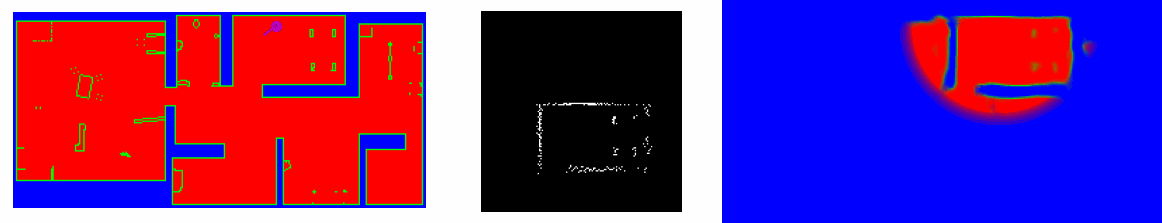

In [18]:
# replay
display.Image('slam_animation1.gif')

n: (223, 1162, 3) x uint8: 0 - 254


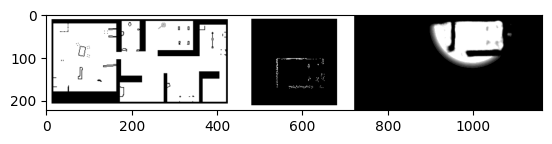

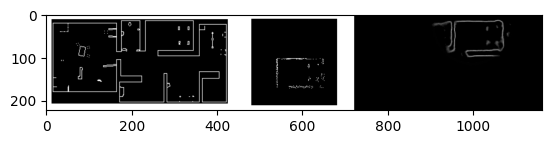

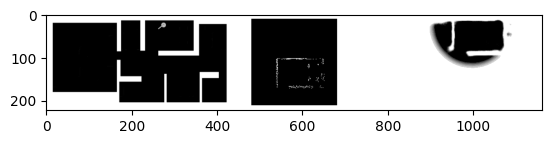

In [47]:
itr = iio.imiter('slam_animation1.gif')
n = next(itr)
print(f"n: {n.shape} x {n.dtype}: {np.min(n)} - {np.max(n)}")
plt.imshow(n[..., 0], cmap='gray')
plt.show()
plt.imshow(n[..., 1], cmap='gray')
plt.show()
plt.imshow(n[..., 2], cmap='gray')
plt.show()

Now let's get more technical...

100%|██████████| 50/50 [00:08<00:00,  6.11it/s]


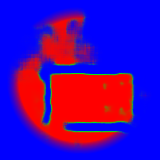

In [68]:
# show that the problem still exists when standing in one place and using a simplified animation loop
reload(slam_operations)
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2-with-trajectory.png')

#trajectory_coords = np.array([[186.5, 8.5]]), (10,1)) * lds.__PIXEL_SIZE__
#trajectory_coords = np.tile(np.array([[186.5, 8.5]]), (10,1)) * lds.__PIXEL_SIZE__
#trajectory_angles = np.tile(np.array([2.48054948]), (trajectory_coords.shape[0],))

def to_rgb(tensor):
  return np.round(tensor.numpy() * 255).astype(np.uint8)

def animate_effect(coord_px, angle, num=10):
  coord = coord_px * lds.__PIXEL_SIZE__

  global_map = slam_data.unknown_map((160,160))
  global_map_start = coord - (np.array([80., 80.]) * lds.__PIXEL_SIZE__)

  frames = []
  for i in tqdm.tqdm(range(num)):
    (map_pred, accept, delta_location, delta_orientation), (input_map, input_lds) = slam_operations.predict_at_location(
        floorplan, global_map, global_map_start, model, coord, angle)

    global_map, global_map_start = slam_operations.update_map(global_map, global_map_start, map_pred, coord)

    frames.append(to_rgb(global_map))

  iio.imwrite('slide_animation1.gif', frames, fps=2)
  idisplay.display(idisplay.Image('slide_animation1.gif'))


animate_effect(np.array([186.5, 8.5]), 2.48054948)

In [63]:
np.array([0, 128, 255, 256, 380]).astype(np.uint8)

array([  0, 128, 255,   0, 124], dtype=uint8)

start_fpx: [-75. -75.]
start_px: [-75 -75]
loc_alignment_offset_fpx: [0.5 0. ]


100%|██████████| 20/20 [00:03<00:00,  5.97it/s]


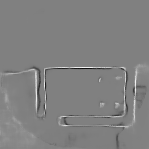

In [82]:
# show that the problem still exists when cutting back to basic model prediction without any global map updates
reload(slam_operations)
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2-with-trajectory.png')

#trajectory_coords = np.array([[186.5, 8.5]]), (10,1)) * lds.__PIXEL_SIZE__
#trajectory_coords = np.tile(np.array([[186.5, 8.5]]), (10,1)) * lds.__PIXEL_SIZE__
#trajectory_angles = np.tile(np.array([2.48054948]), (trajectory_coords.shape[0],))

def to_rgb(tensor):
  if np.min(tensor) < 0:
    return np.round(tensor.numpy() * 127 + 128).astype(np.uint8)
  else:
    return np.round(tensor.numpy() * 255).astype(np.uint8)

def animate_effect(coord_px, angle, num=20, delta=False):
  coord = coord_px * lds.__PIXEL_SIZE__

  centre_fpx = np.array([(149-1)/2, (149-1)/2])
  start_fpx = centre_fpx - 149
  start_px = np.round(start_fpx).astype(np.int32)
  loc_alignment_offset_fpx = start_fpx - start_px

  loc_alignment_offset_fpx = np.array([+0.5, 0.0])
  print(f"start_fpx: {start_fpx}")
  print(f"start_px: {start_px}")
  print(f"loc_alignment_offset_fpx: {loc_alignment_offset_fpx}")

  map_window = slam_data.unknown_map((149,149))

  frames = []
  first = None
  for i in tqdm.tqdm(range(num)):
    occupancy_map = floorplan[..., slam_data.__OBSTRUCTION_IDX__]
    ranges = lds.lds_sample(occupancy_map, coord, angle)
    lds_map = lds.lds_to_occupancy_map(ranges, angle=angle, size_px=149, centre_px=loc_alignment_offset_fpx)

    map_input = tf.expand_dims(map_window, axis=0)
    lds_input = tf.expand_dims(lds_map, axis=0)

    map_output, adlo_output = model.predict((map_input, lds_input), verbose=0)
    map_window = tf.math.softmax(map_output[0], axis=-1)

    if delta:
      if first == None:
        first = map_window
      else:
        frames.append(to_rgb(map_window[..., 1] - first[..., 1]))
    else:
      frames.append(to_rgb(map_window))

  iio.imwrite('slide_animation2.gif', frames, fps=2)
  idisplay.display(idisplay.Image('slide_animation2.gif'))


animate_effect(np.array([186.5, 8.5]), 2.48054948, num=20, delta=True)

loc_alignment_offset_fpx: [-0.5 -0.5]
loc_alignment_offset_fpx: [-0.25 -0.5 ]
loc_alignment_offset_fpx: [ 0.  -0.5]
loc_alignment_offset_fpx: [ 0.25 -0.5 ]


KeyboardInterrupt: 

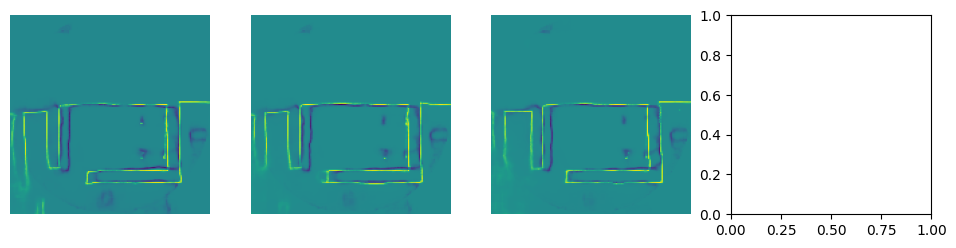

In [92]:
# see if loc_alignment_offset_fpx is the problem by trying out a few different values and looking at the result after 10 iterations each time
reload(slam_operations)
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2-with-trajectory.png')

def to_rgb(tensor):
  if np.min(tensor) < 0:
    return np.round(tensor.numpy() * 127 + 128).astype(np.uint8)
  else:
    return np.round(tensor.numpy() * 255).astype(np.uint8)

def show_effect(coord_px, angle, num, loc_alignment_offset_fpx, delta=False):
  np.random.seed(0)
  tf.random.set_seed(0)
  coord = coord_px * lds.__PIXEL_SIZE__
  print(f"loc_alignment_offset_fpx: {loc_alignment_offset_fpx}")
  map_window = slam_data.unknown_map((149,149))

  first = None
  last = None
  for i in range(num):
    occupancy_map = floorplan[..., slam_data.__OBSTRUCTION_IDX__]
    ranges = lds.lds_sample(occupancy_map, coord, angle)
    lds_map = lds.lds_to_occupancy_map(ranges, angle=angle, size_px=149, centre_px=loc_alignment_offset_fpx)

    map_input = tf.expand_dims(map_window, axis=0)
    lds_input = tf.expand_dims(lds_map, axis=0)

    map_output, adlo_output = model.predict((map_input, lds_input), verbose=0)
    map_window = tf.math.softmax(map_output[0], axis=-1)

    if first == None:
      first = map_window

  last = map_window
  res = to_rgb(last[..., 1] - first[..., 1])

  plt.imshow(res)
  plt.axis('off')

plt.figure(figsize=(15,15))
cnt = 1
for dy in np.linspace(-0.5, +0.5, 5, endpoint=True):
  for dx in np.linspace(-0.5, +0.5, 5, endpoint=True):
    plt.subplot(5,5,cnt)
    show_effect(np.array([186.5, 8.5]), 2.48054948, num=10, loc_alignment_offset_fpx=np.array([dx, dy]), delta=True)
    cnt += 1
plt.show()

loc_alignment_offset_fpx: [-5. -5.]
loc_alignment_offset_fpx: [-2.5 -5. ]
loc_alignment_offset_fpx: [ 0. -5.]
loc_alignment_offset_fpx: [ 2.5 -5. ]
loc_alignment_offset_fpx: [ 5. -5.]
loc_alignment_offset_fpx: [-5.  -2.5]
loc_alignment_offset_fpx: [-2.5 -2.5]
loc_alignment_offset_fpx: [ 0.  -2.5]
loc_alignment_offset_fpx: [ 2.5 -2.5]
loc_alignment_offset_fpx: [ 5.  -2.5]
loc_alignment_offset_fpx: [-5.  0.]
loc_alignment_offset_fpx: [-2.5  0. ]
loc_alignment_offset_fpx: [0. 0.]
loc_alignment_offset_fpx: [2.5 0. ]
loc_alignment_offset_fpx: [5. 0.]
loc_alignment_offset_fpx: [-5.   2.5]
loc_alignment_offset_fpx: [-2.5  2.5]
loc_alignment_offset_fpx: [0.  2.5]
loc_alignment_offset_fpx: [2.5 2.5]
loc_alignment_offset_fpx: [5.  2.5]
loc_alignment_offset_fpx: [-5.  5.]
loc_alignment_offset_fpx: [-2.5  5. ]
loc_alignment_offset_fpx: [0. 5.]
loc_alignment_offset_fpx: [2.5 5. ]
loc_alignment_offset_fpx: [5. 5.]


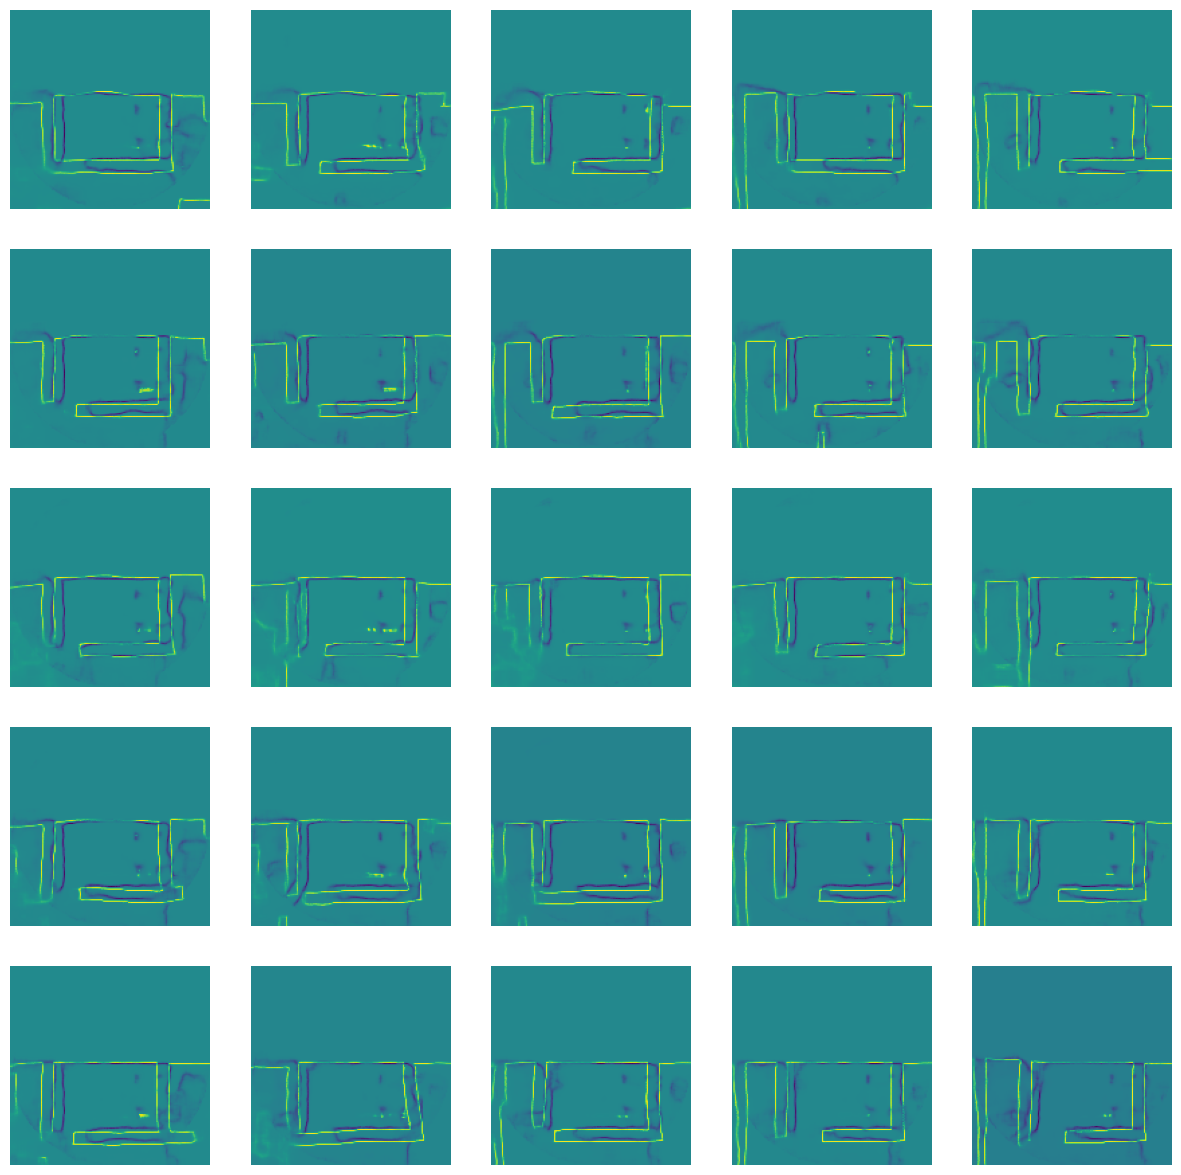

In [93]:
# checking whether loc_alignment_offset_fpx has any effect at all - when using stupid large values
plt.figure(figsize=(15,15))
cnt = 1
for dy in np.linspace(-5, +5, 5, endpoint=True):
  for dx in np.linspace(-5, +5, 5, endpoint=True):
    plt.subplot(5,5,cnt)
    show_effect(np.array([186.5, 8.5]), 2.48054948, num=10, loc_alignment_offset_fpx=np.array([dx, dy]), delta=True)
    cnt += 1
plt.show()

In [89]:
np.linspace(-0.5, +0.5, 5, endpoint=True)

array([-0.5 , -0.25,  0.  ,  0.25,  0.5 ])

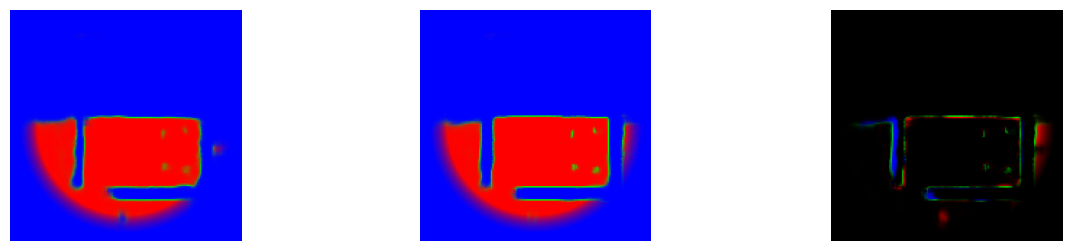

In [26]:
reload(slam_operations)
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2-with-trajectory.png')

#trajectory_coords = np.array([[186.5, 8.5]]), (10,1)) * lds.__PIXEL_SIZE__
#trajectory_coords = np.tile(np.array([[186.5, 8.5]]), (10,1)) * lds.__PIXEL_SIZE__
#trajectory_angles = np.tile(np.array([2.48054948]), (trajectory_coords.shape[0],))

def show_effect(coord_px, angle):
  coord = coord_px * lds.__PIXEL_SIZE__

  global_map = slam_data.unknown_map((160,160))
  global_map_start = coord - (np.array([80., 80.]) * lds.__PIXEL_SIZE__)

  (map_pred, accept, delta_location, delta_orientation), (input_map, input_lds) = slam_operations.predict_at_location(
      floorplan, global_map, global_map_start, model, coord, angle)

  global_map, global_map_start = slam_operations.update_map(global_map, global_map_start, map_pred, coord)
  gm1 = global_map

  (map_pred, accept, delta_location, delta_orientation), (input_map, input_lds) = slam_operations.predict_at_location(
      floorplan, global_map, global_map_start, model, coord, angle)

  global_map, global_map_start = slam_operations.update_map(global_map, global_map_start, map_pred, coord)

  plt.figure(figsize=(15,3))

  plt.subplot(1,3,1)
  #plt.imshow(input_map)
  plt.imshow(gm1)
  plt.axis('off')

  plt.subplot(1,3,2)
  #plt.imshow(map_pred)
  plt.imshow(global_map)
  plt.axis('off')

  plt.subplot(1,3,3)
  #plt.imshow(map_pred)
  plt.imshow(global_map - gm1)
  plt.axis('off')

  plt.show()


show_effect(np.array([186.5, 8.5]), 2.48054948)


### More direct analysis
There appears to be a problem with the generated map being offset relative to the input LDS data. Let's confirm that.

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


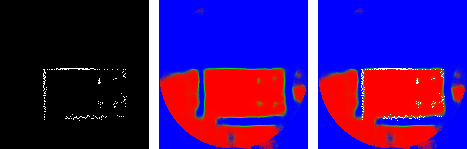

In [47]:
# First without any input map, then with an input map.

reload(slam_operations)
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2-with-trajectory.png')

def to_rgb(tensor):
  if (tensor.ndim == 2):
    tensor = tf.expand_dims(tensor, axis=2)
    tensor = tf.tile(tensor, (1,1,3))

  if np.min(tensor) < 0:
    return np.round(tensor.numpy() * 127 + 128).astype(np.uint8)
  else:
    return np.round(tensor.numpy() * 255).astype(np.uint8)

np.random.seed(0)
tf.random.set_seed(0)
coord = np.array([186., 8.])  * lds.__PIXEL_SIZE__
angle = 2.48054948
map_window = slam_data.unknown_map((149,149))

occupancy_map = floorplan[..., slam_data.__OBSTRUCTION_IDX__]
ranges = lds.lds_sample(occupancy_map, coord, angle)
lds_map = lds.lds_to_occupancy_map(ranges, angle=angle, size_px=149, centre_px=(0,0))

def generate_effect(map_window):
  np.random.seed(0)
  tf.random.set_seed(0)
  map_input = tf.expand_dims(map_window, axis=0)
  lds_input = tf.expand_dims(lds_map, axis=0)

  map_output, adlo_output = model.predict((map_input, lds_input), verbose=0)
  map_output = tf.math.softmax(map_output[0], axis=-1)

  #print(f"input_map:  {map_window.shape}")
  #print(f"lds_map:    {lds_map.shape} in range {np.min(lds_map)} - {np.max(lds_map)}")
  #print(f"output_map: {map_output.shape}")
  return map_output

num = 100
step = 1
rows = num // step
frames = []
for i in tqdm.tqdm(range(num)):
  cnt = i * 3
  map_output = generate_effect(map_window)
  map_window = map_output

  combined = tf.clip_by_value(map_output + lds_map[..., np.newaxis], 0.0, 1.0)

  frame = np.ones((149, 149*3+10*2, 3), dtype=np.uint8)*255

  frame[:, 0:149, :] = to_rgb(lds_map)
  frame[:, (10+149):(10+149*2), :] = to_rgb(map_output)
  frame[:, (20+149*2):(20+149*3), :] = to_rgb(combined)
  frames.append(frame)

iio.imwrite('slide_animation3.gif', frames, fps=2)
idisplay.display(idisplay.Image('slide_animation3.gif'))

Learnings:
* The trained model itself is the cause of this shift. But there's a few possible components to it:
  1. The model itself may be the direct cause of the shift, or the shift may be caused by bugs in the dataset that train the model to shift its output a little to the left.
  2. The model is retaining fake walls even as they pass through the centre of the LDS data. Why does the model not fix them? This means that it's never been trained on scenarios like this.


## Review dataset
Now that we've confirmed there's a problem with the trained model itself, let's first look for evidence of alignment problems in the original dataset.

The training dataset intentionally simulates random errors on all examples. So we can't just naively superimpose LDS data and expect to see a perfect alignment. Instead, I'll have to remove the intentional alignment errors first.

Note that I'll be rotating and translating the LDS map in order to overlay it onto the semantic map. This is technically half-backwards, as the simulated tracking problem causes the incorrect window position when sampling the input map from the global map, however the orientation tracking error does indeed lead to the LDS map being rotated. But this half-backwards approach reflects the way that we've trained the network.

In [48]:
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data5.npz')

Loaded:
  input_maps:  (1000, 149, 149, 3) x float32
  lds_maps:    (1000, 149, 149) x float32
  output_maps: (1000, 149, 149, 3) x float32
  adlos:       (1000, 4) x float32
  metadatas:   (1000, 8) x float32
Dataset loaded from repo/data/experimental-slam-training-data5.npz


-- sample type 0 --
centre: [74. 74.], DL=[0. 0.], DO: 0.0
centre: [73.79629517 73.85287476], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.20370483 -0.14712524]
metadata: agent     @ [173.7963   116.852875] by 128.86041259765625


<Figure size 1000x400 with 0 Axes>

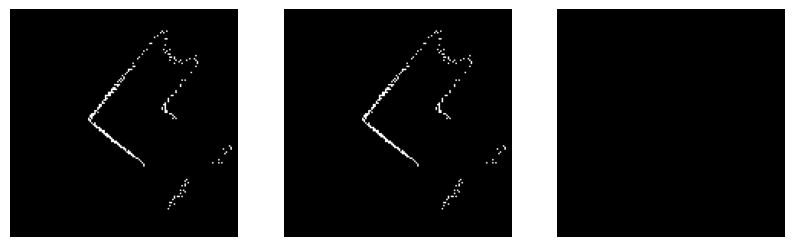

centre: [74. 74.], DL=[0. 0.], DO: 0.0
centre: [74.48204041 73.54418945], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [ 0.4820404  -0.45581055]
metadata: agent     @ [254.48204  36.54419] by 166.9495849609375


<Figure size 1000x400 with 0 Axes>

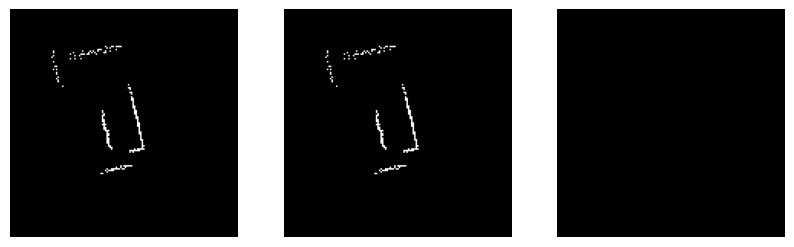

centre: [74. 74.], DL=[0. 0.], DO: 0.0
centre: [73.65704346 74.33798409], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.34295654  0.33798409]
metadata: agent     @ [205.65704   26.337984] by -63.01599884033203


<Figure size 1000x400 with 0 Axes>

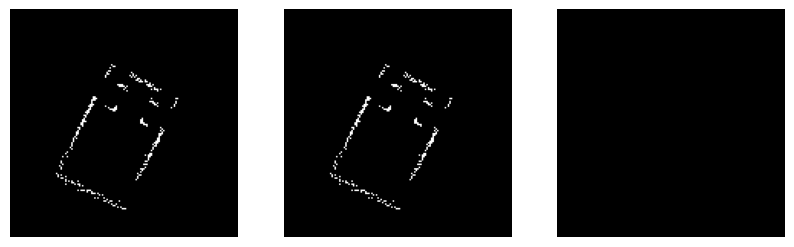

centre: [74. 74.], DL=[0. 0.], DO: 0.0
centre: [73.79417419 73.84069824], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.2058258  -0.15930176]
metadata: agent     @ [191.79417  46.8407 ] by -152.7494354248047


<Figure size 1000x400 with 0 Axes>

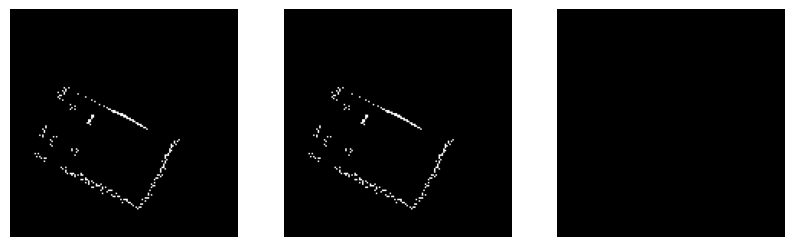

centre: [74. 74.], DL=[0. 0.], DO: 0.0
centre: [73.71668434 74.44444275], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.28331566  0.44444275]
metadata: agent     @ [29.716684 14.444443] by -129.13815307617188


<Figure size 1000x400 with 0 Axes>

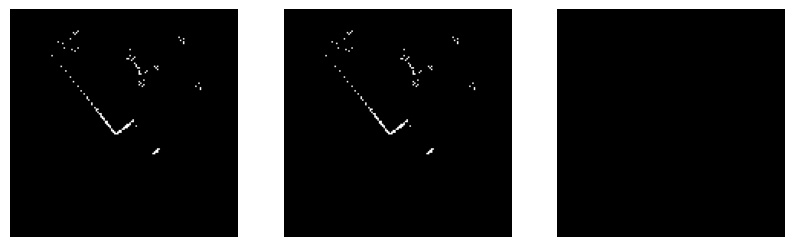

-- sample type 1 --
centre: [74. 74.], DL=[ -6.3431525 -13.211768 ], DO: 11.446252822875977
centre: [74.05664062 74.14541626], DL=[ -6.3431525 -13.211768 ], DO: 11.446252822875977
adlo:     delta     @ [ -6.3431525 -13.211768 ] by 11.446252822875977
metadata: input_map @ [ 69.05664 113.14542] by 0.0, fpx_offset: [0.05664062 0.14541626]
metadata: agent     @ [62.71349 99.93364] by -26.52892303466797


<Figure size 1000x400 with 0 Axes>

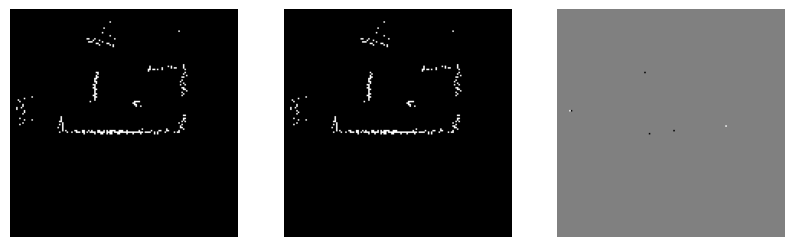

centre: [74. 74.], DL=[-0.06819189  3.0443778 ], DO: 7.860408306121826
centre: [74.28509521 74.1027298 ], DL=[-0.06819189  3.0443778 ], DO: 7.860408306121826
adlo:     delta     @ [-0.06819189  3.0443778 ] by 7.860408306121826
metadata: input_map @ [250.2851   55.10273] by 0.0, fpx_offset: [0.2850952 0.1027298]
metadata: agent     @ [250.2169    58.147102] by -33.18524932861328


<Figure size 1000x400 with 0 Axes>

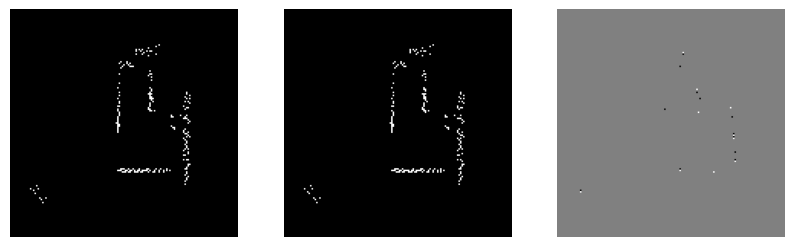

centre: [74. 74.], DL=[ -3.908571 -10.28917 ], DO: 5.280980110168457
centre: [73.87966919 73.98262024], DL=[ -3.908571 -10.28917 ], DO: 5.280980110168457
adlo:     delta     @ [ -3.908571 -10.28917 ] by 5.280980110168457
metadata: input_map @ [221.87967 136.98262] by 0.0, fpx_offset: [-0.12033081 -0.01737976]
metadata: agent     @ [217.9711  126.69344] by 34.14410400390625


<Figure size 1000x400 with 0 Axes>

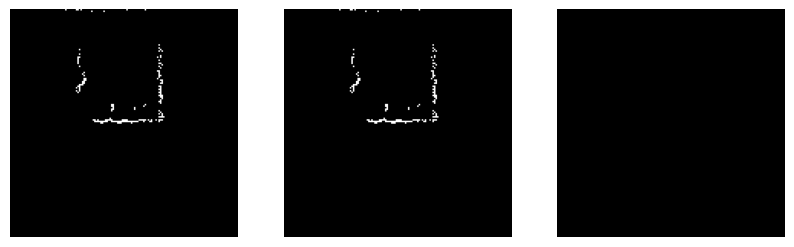

centre: [74. 74.], DL=[-2.3370569  -0.69479895], DO: 4.5558271408081055
centre: [74.43919373 73.64788818], DL=[-2.3370569  -0.69479895], DO: 4.5558271408081055
adlo:     delta     @ [-2.3370569  -0.69479895] by 4.5558271408081055
metadata: input_map @ [ 32.439194 101.64789 ] by 0.0, fpx_offset: [ 0.43919373 -0.35211182]
metadata: agent     @ [ 30.102135 100.953094] by -101.95988464355469


<Figure size 1000x400 with 0 Axes>

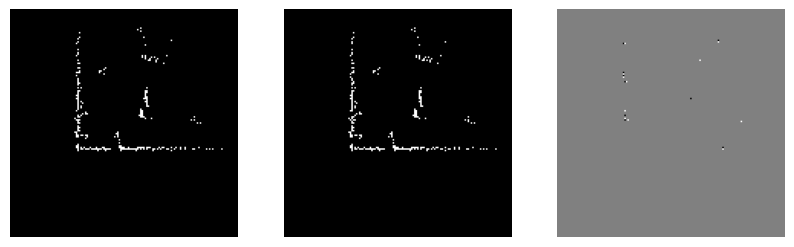

centre: [74. 74.], DL=[-4.119527    0.37853414], DO: 3.070713996887207
centre: [74.08421326 73.92869949], DL=[-4.119527    0.37853414], DO: 3.070713996887207
adlo:     delta     @ [-4.119527    0.37853414] by 3.070713996887207
metadata: input_map @ [228.08421  27.9287 ] by 0.0, fpx_offset: [ 0.08421326 -0.07130051]
metadata: agent     @ [223.96469   28.307232] by -37.958003997802734


<Figure size 1000x400 with 0 Axes>

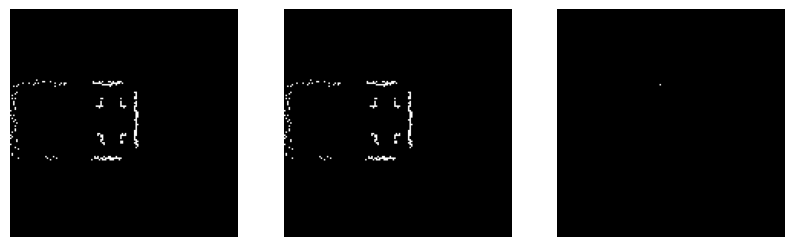

-- sample type 2 --
centre: [74. 74.], DL=[  9.90941  -19.680294], DO: -56.75674057006836
centre: [73.853302   73.58704376], DL=[  9.90941  -19.680294], DO: -56.75674057006836
adlo:     delta     @ [  9.90941  -19.680294] by -56.75674057006836
metadata: input_map @ [277.8533    32.587044] by 0.0, fpx_offset: [-0.146698   -0.41295624]
metadata: agent     @ [287.7627    12.906751] by 130.84942626953125


<Figure size 1000x400 with 0 Axes>

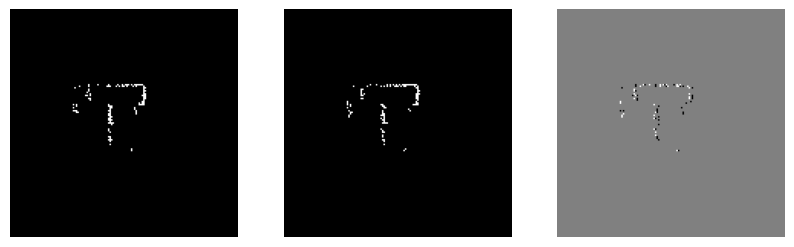

centre: [74. 74.], DL=[13.04323 72.50247], DO: -13.06991195678711
centre: [74.00107574 74.00498199], DL=[13.04323 72.50247], DO: -13.06991195678711
adlo:     delta     @ [13.04323 72.50247] by -13.06991195678711
metadata: input_map @ [120.001076  37.004982] by 0.0, fpx_offset: [0.00107574 0.00498199]
metadata: agent     @ [133.04431  109.507454] by 67.06832122802734


<Figure size 1000x400 with 0 Axes>

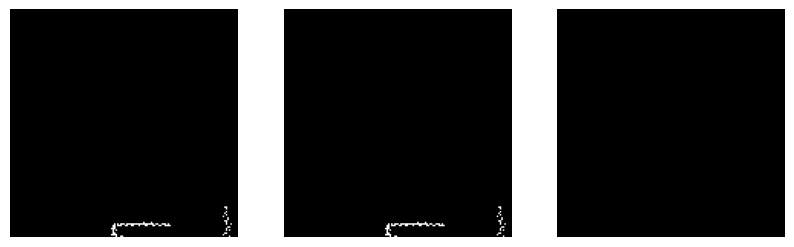

centre: [74. 74.], DL=[  0.32458082 -19.187351  ], DO: 131.7184600830078
centre: [73.82135105 73.88021088], DL=[  0.32458082 -19.187351  ], DO: 131.7184600830078
adlo:     delta     @ [  0.32458082 -19.187351  ] by 131.7184600830078
metadata: input_map @ [ 12.821351 103.88021 ] by 0.0, fpx_offset: [-0.17864895 -0.11978912]
metadata: agent     @ [13.145931 84.69286 ] by -59.88203430175781


<Figure size 1000x400 with 0 Axes>

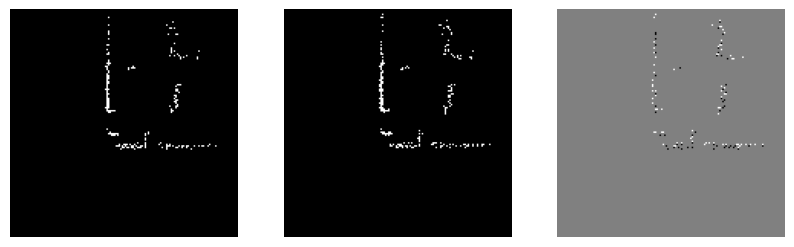

centre: [74. 74.], DL=[-40.3909 -39.4088], DO: -117.48709106445312
centre: [74.41195679 74.31548309], DL=[-40.3909 -39.4088], DO: -117.48709106445312
adlo:     delta     @ [-40.3909 -39.4088] by -117.48709106445312
metadata: input_map @ [294.41196  88.31548] by 0.0, fpx_offset: [0.4119568 0.3154831]
metadata: agent     @ [254.02104   48.906693] by -175.58096313476562


<Figure size 1000x400 with 0 Axes>

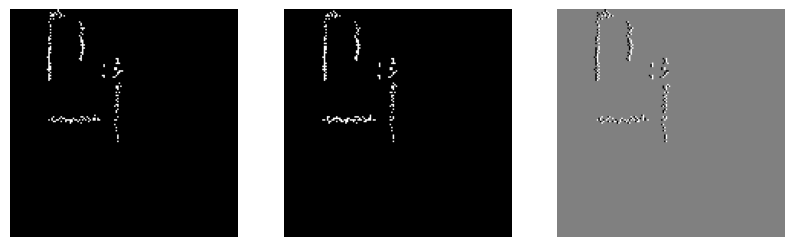

centre: [74. 74.], DL=[-57.6663    42.541122], DO: 44.43235778808594
centre: [73.7387085  73.88622665], DL=[-57.6663    42.541122], DO: 44.43235778808594
adlo:     delta     @ [-57.6663    42.541122] by 44.43235778808594
metadata: input_map @ [317.7387   -28.113773] by 0.0, fpx_offset: [-0.2612915  -0.11377335]
metadata: agent     @ [260.0724    14.427347] by -121.38842010498047


<Figure size 1000x400 with 0 Axes>

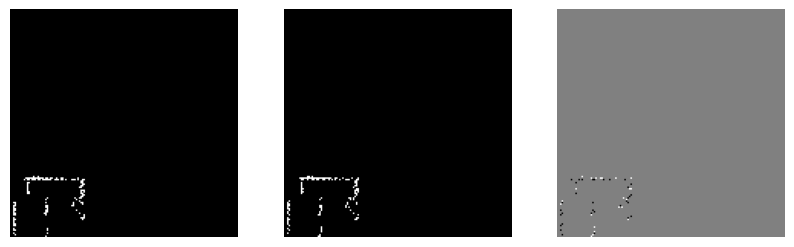

-- sample type 3 --
centre: [74. 74.], DL=[0. 0.], DO: 0.0
centre: [73.89830208 74.30261993], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [ 20.898302 113.30262 ] by 0.0, fpx_offset: [-0.10169792  0.30261993]
metadata: agent     @ [162.497  108.1064] by -170.71397399902344


<Figure size 1000x400 with 0 Axes>

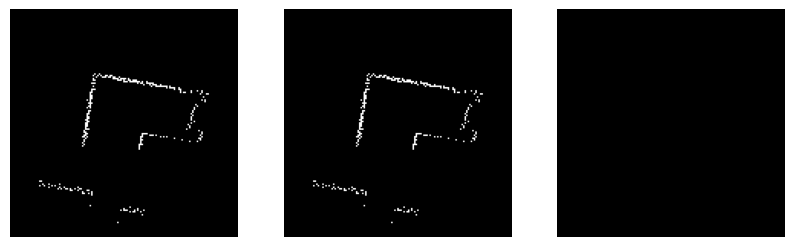

centre: [74. 74.], DL=[0. 0.], DO: 0.0
centre: [73.53901672 73.59795761], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [221.53902   60.597958] by 0.0, fpx_offset: [-0.46098328 -0.4020424 ]
metadata: agent     @ [17.337555 32.404034] by 42.59235763549805


<Figure size 1000x400 with 0 Axes>

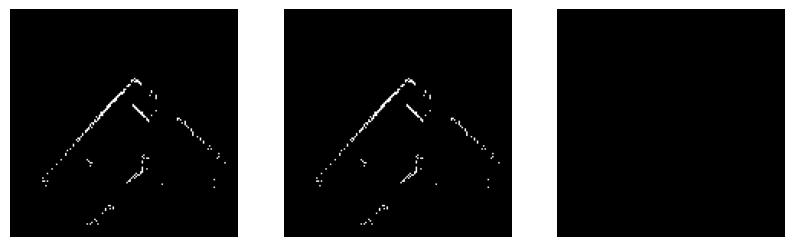

centre: [74. 74.], DL=[0. 0.], DO: 0.0
centre: [74.2043457  74.49439359], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [176.20435     2.4943936] by 0.0, fpx_offset: [0.2043457 0.4943936]
metadata: agent     @ [11.381504 22.324327] by -24.46354103088379


<Figure size 1000x400 with 0 Axes>

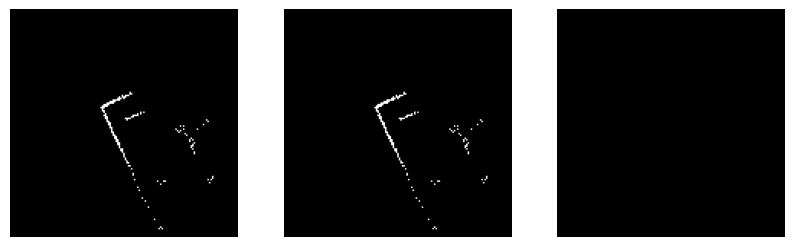

centre: [74. 74.], DL=[0. 0.], DO: 0.0
centre: [73.61391449 74.2096138 ], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [83.613914 33.209614] by 0.0, fpx_offset: [-0.3860855  0.2096138]
metadata: agent     @ [207.59177   36.816566] by 149.3921356201172


<Figure size 1000x400 with 0 Axes>

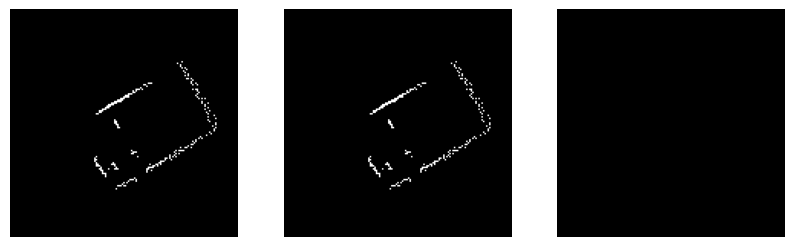

centre: [74. 74.], DL=[0. 0.], DO: 0.0
centre: [74.00678253 74.21487808], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [70.00678  40.214878] by 0.0, fpx_offset: [0.00678253 0.21487808]
metadata: agent     @ [247.4261    20.575056] by 112.04386901855469


<Figure size 1000x400 with 0 Axes>

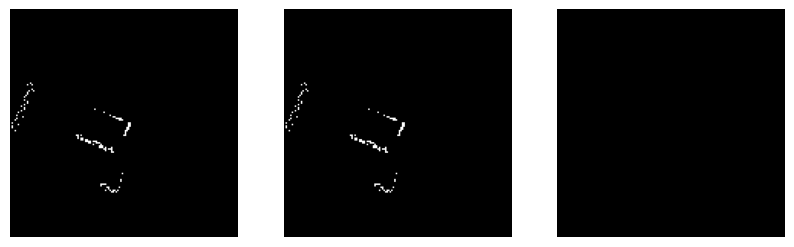

In [114]:
# first let's look at the effect of the fpx_offset on LDS maps
def show_data_sample(input_map, lds_map, output_map, adlo, metadata):
  dl = np.array([adlo[1], adlo[2]]) * 149
  do = np.rad2deg(adlo[3] * np.pi)

  sample_type = tf.cast(metadata[1], tf.int32)
  md_iml = np.array([metadata[2], metadata[3]]) / lds.__PIXEL_SIZE__
  md_imo = np.rad2deg(metadata[4])
  md_agl = np.array([metadata[5], metadata[6]]) / lds.__PIXEL_SIZE__
  md_ago = np.rad2deg(metadata[7])

  if sample_type == 0:
    im_fpx_offset = md_agl - np.round(md_agl)
  else:
    im_fpx_offset = md_iml - np.round(md_iml)

  lds_map1 = fix_lds(lds_map, adlo)
  lds_map2 = fix_lds(lds_map, adlo, im_fpx_offset)

  plt.figure(figsize=(10,4))

  print(f"adlo:     delta     @ {dl} by {do}")
  print(f"metadata: input_map @ {md_iml} by {md_imo}, fpx_offset: {im_fpx_offset}")
  print(f"metadata: agent     @ {md_agl} by {md_ago}")

  plt.figure(figsize=(10,4))

  plt.subplot(1,3,1)
  plt.imshow(lds_map1, cmap='gray')
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(lds_map2, cmap='gray')
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(diff_images(lds_map1, lds_map2), cmap='gray')
  plt.axis('off')

  plt.show()

def show_dataset_alignment(dataset, num, sample_types):
    filtered = filter_dataset(dataset, num, sample_types)
    for (input_map, lds_map), (output_map, adlo), metadata in filtered:
        show_data_sample(input_map, lds_map, output_map, adlo, metadata)


print("-- sample type 0 --")
show_dataset_alignment(train_data, 5, sample_types=0)
print("-- sample type 1 --")
show_dataset_alignment(train_data, 5, sample_types=1)
print("-- sample type 2 --")
show_dataset_alignment(train_data, 5, sample_types=2)
print("-- sample type 3 --")
show_dataset_alignment(train_data, 5, sample_types=3)

**Analysis**

Sample Type 0:
* code:
  * output map is centred exactly on fpx location, shifting that section of the global by a sub-pixel amount towards the exact centre of the window
  * however the LDS map is shifted by fpx so that it is positioned off-centre.
  * this is incorrect
  * suggest verifying by rounding to nearest 10px instead of 1px
* plots above:
  * there is no shift due to the fact that the fpx_offset is only used during rotation and there is no rotation.
  * I think this is correct

```python
map_known=False
location = agent_location
location_alignment_offset_fpx = location_fpx - location_px
input_map = unknown_map(window_size_px, unknown_value=unknown_value)
output_map = map_from_lds_train_data.rotated_crop(centre=agent_location_fpx, orientation, ...))
lds_map = lds.lds_to_occupancy_map(centre_px=agent_location_fpx_offset, ...)
```

Sample Type 1:
* code: seems correct
* plots above: very minor changes with no obvious trend
* everything looks correct here

```python
map_known=True
location = map_location
agent_location = map_location - loc_error
input_map = map_from_lds_train_data.rotated_crop(centre=map_location_px, ...)
output_map = map_from_lds_train_data.rotated_crop(centre=map_location_px, ...)
lds_map = lds.lds_to_occupancy_map(centre_px=map_location_fpx_offset, ...)
```


Sample Type 2:
* code: seems correct
* plots above: clear shift between LDS map versions, direction changes per image.
* On the face of it there looks to be a problem.
* After a little more thinking, the reason for differences to appear stronger here is that it depends on the angle of rotation.
	Sample Type 2 has more angles near the four 45-degrees, which is where the differences in rotation centres has the greatest effect.
	So the visually apparent magnitude of problems here are an anomaly that masks the real problems.
	Alternatively, the visual magnitude of the problems may well translate into the same magnitude of data errors in the training set.

```python
map_known=True
location = map_location
agent_location = map_location - loc_error
...same as for Sample Type 1...
```

Sample Type 3:
* code: same as for Sample Type 0, I think there's a mistake
* plots: nothing to see
* outcome: same as for Sample Type 0. Need to verify.

```python
input_map: location = map_location, map_known=True
lds_map, output_map: location = agent_location, map_known=False
agent_location = somewhere else
input_map = ..irrelevant..
output_map = map_from_lds_train_data.rotated_crop(centre=agent_location_fpx, ...)
lds_map = lds.lds_to_occupancy_map(centre_px=agent_location_fpx_offset, ...)
```

Summary:
* I believe Sample Types 0 and 3 have a mistake in their use of fpx_offset, it just can't be seen in these plots.
* It's unclear whether the visually obvious problems with Sample Type 2 are indicative of real problems. The code seems correct.
* Also note that we can't be certain using this data. The LDS map data has been discretized so trying to shift by < 0.5px will result in no change. Without the original range data we cannot really see what the outcome would look like.
* From these results, I'd expect the model-induced shift in the output map to be:
	* worst: Sample Types 0, 3
	* maybe: Sample Type 2
	* negligeable: Sample Type 1
* But we can't be sure about the errors until we try re-generating the test data.




-- sample type 0 --
centre: [73.79629517 73.85287476], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.20370483 -0.14712524]
metadata: agent     @ [173.7963   116.852875] by 128.86041259765625
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

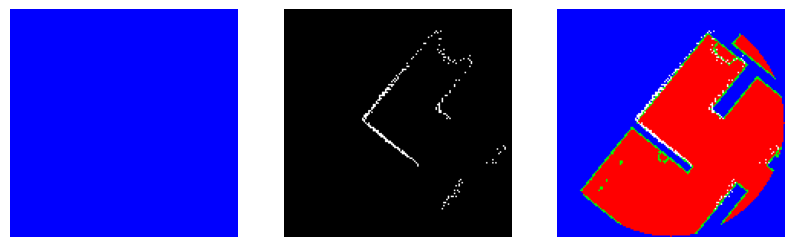

centre: [74.48204041 73.54418945], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [ 0.4820404  -0.45581055]
metadata: agent     @ [254.48204  36.54419] by 166.9495849609375
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

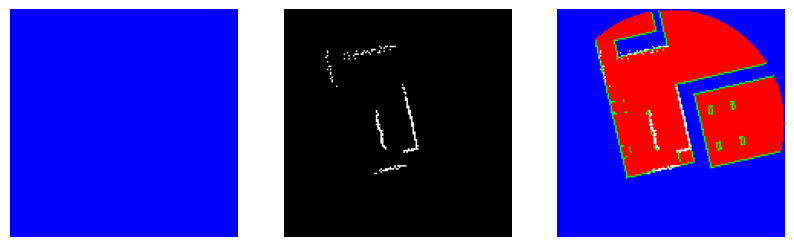

centre: [73.65704346 74.33798409], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.34295654  0.33798409]
metadata: agent     @ [205.65704   26.337984] by -63.01599884033203
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

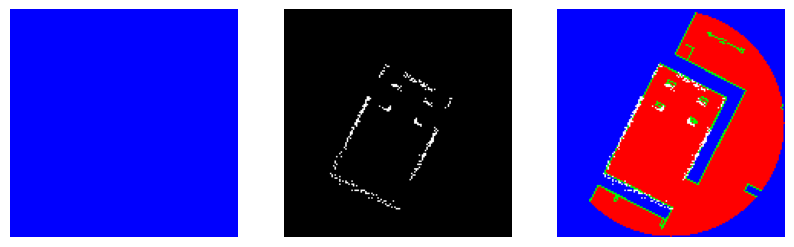

centre: [73.79417419 73.84069824], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.2058258  -0.15930176]
metadata: agent     @ [191.79417  46.8407 ] by -152.7494354248047
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

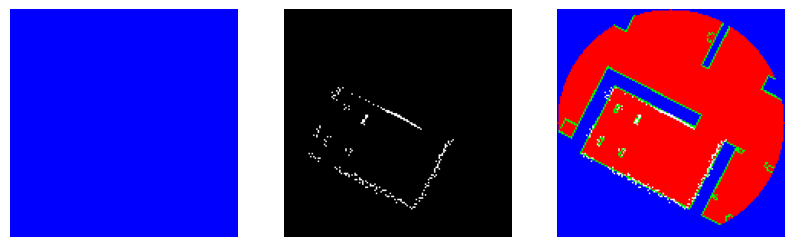

centre: [73.71668434 74.44444275], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.28331566  0.44444275]
metadata: agent     @ [29.716684 14.444443] by -129.13815307617188
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

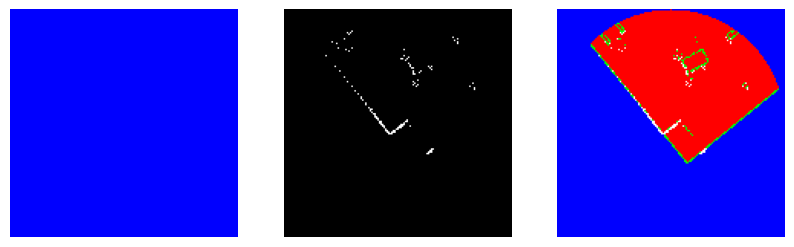

-- sample type 1 --
centre: [74.05664062 74.14541626], DL=[ -6.3431525 -13.211768 ], DO: 11.446252822875977
adlo:     delta     @ [ -6.3431525 -13.211768 ] by 11.446252822875977
metadata: input_map @ [ 69.05664 113.14542] by 0.0, fpx_offset: [0.05664062 0.14541626]
metadata: agent     @ [62.71349 99.93364] by -26.52892303466797
metadata: delta     @ [ -6.343151 -13.211777] by -26.52892303466797


<Figure size 1000x400 with 0 Axes>

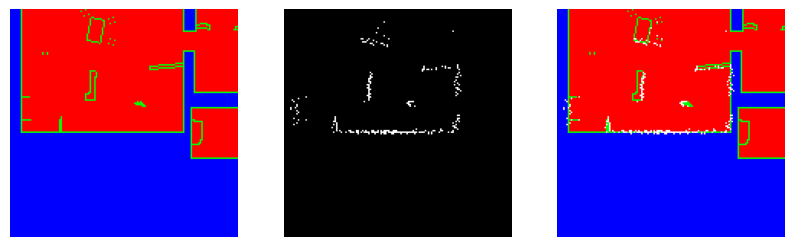

centre: [74.28509521 74.1027298 ], DL=[-0.06819189  3.0443778 ], DO: 7.860408306121826
adlo:     delta     @ [-0.06819189  3.0443778 ] by 7.860408306121826
metadata: input_map @ [250.2851   55.10273] by 0.0, fpx_offset: [0.2850952 0.1027298]
metadata: agent     @ [250.2169    58.147102] by -33.18524932861328
metadata: delta     @ [-0.06819153  3.0443726 ] by -33.18524932861328


<Figure size 1000x400 with 0 Axes>

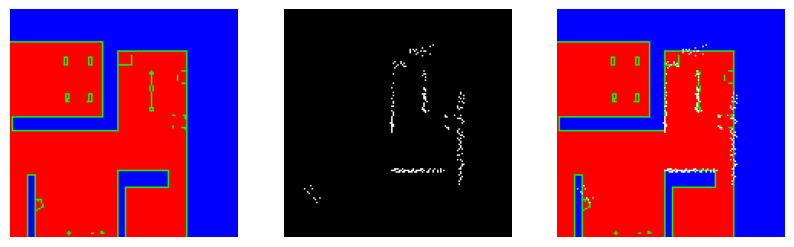

centre: [73.87966919 73.98262024], DL=[ -3.908571 -10.28917 ], DO: 5.280980110168457
adlo:     delta     @ [ -3.908571 -10.28917 ] by 5.280980110168457
metadata: input_map @ [221.87967 136.98262] by 0.0, fpx_offset: [-0.12033081 -0.01737976]
metadata: agent     @ [217.9711  126.69344] by 34.14410400390625
metadata: delta     @ [ -3.9085693 -10.289177 ] by 34.14410400390625


<Figure size 1000x400 with 0 Axes>

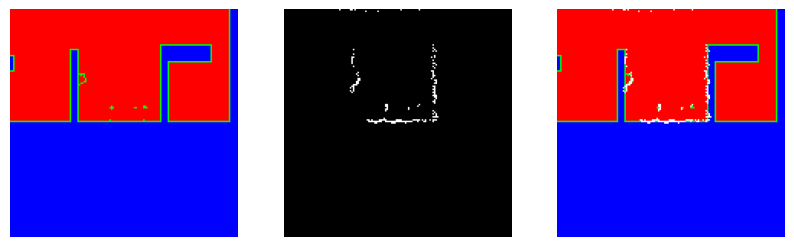

centre: [74.43919373 73.64788818], DL=[-2.3370569  -0.69479895], DO: 4.5558271408081055
adlo:     delta     @ [-2.3370569  -0.69479895] by 4.5558271408081055
metadata: input_map @ [ 32.439194 101.64789 ] by 0.0, fpx_offset: [ 0.43919373 -0.35211182]
metadata: agent     @ [ 30.102135 100.953094] by -101.95988464355469
metadata: delta     @ [-2.337059  -0.6947937] by -101.95988464355469


<Figure size 1000x400 with 0 Axes>

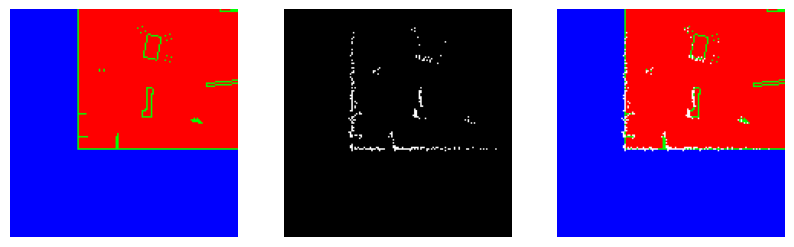

centre: [74.08421326 73.92869949], DL=[-4.119527    0.37853414], DO: 3.070713996887207
adlo:     delta     @ [-4.119527    0.37853414] by 3.070713996887207
metadata: input_map @ [228.08421  27.9287 ] by 0.0, fpx_offset: [ 0.08421326 -0.07130051]
metadata: agent     @ [223.96469   28.307232] by -37.958003997802734
metadata: delta     @ [-4.119522   0.3785324] by -37.958003997802734


<Figure size 1000x400 with 0 Axes>

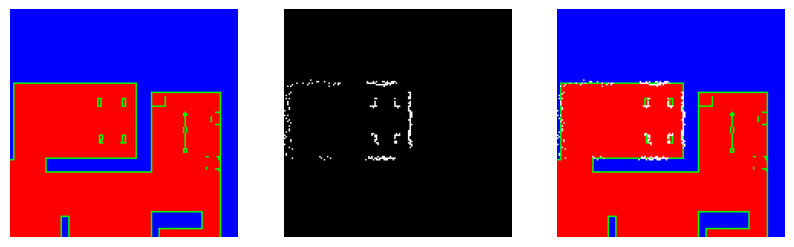

-- sample type 2 --
(no output map to present)
-- sample type 3 --
centre: [73.89830208 74.30261993], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [ 20.898302 113.30262 ] by 0.0, fpx_offset: [-0.10169792  0.30261993]
metadata: agent     @ [162.497  108.1064] by -170.71397399902344
metadata: delta     @ [141.5987     -5.1962204] by -170.71397399902344


<Figure size 1000x400 with 0 Axes>

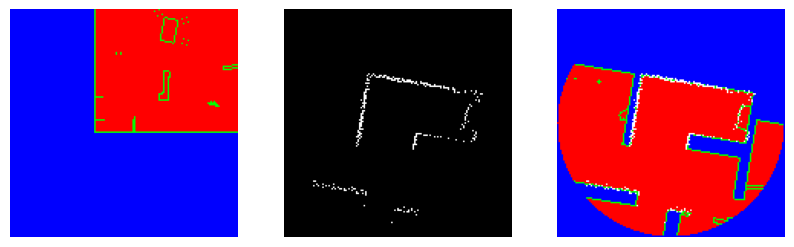

centre: [73.53901672 73.59795761], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [221.53902   60.597958] by 0.0, fpx_offset: [-0.46098328 -0.4020424 ]
metadata: agent     @ [17.337555 32.404034] by 42.59235763549805
metadata: delta     @ [-204.20146   -28.193924] by 42.59235763549805


<Figure size 1000x400 with 0 Axes>

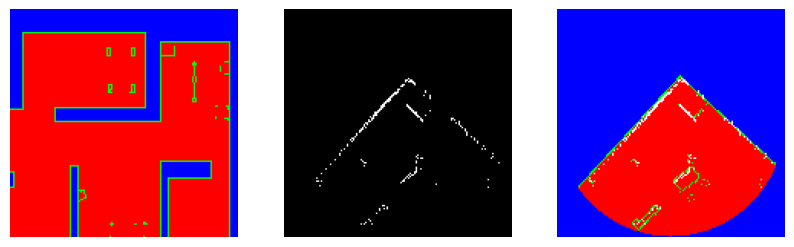

centre: [74.2043457  74.49439359], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [176.20435     2.4943936] by 0.0, fpx_offset: [0.2043457 0.4943936]
metadata: agent     @ [11.381504 22.324327] by -24.46354103088379
metadata: delta     @ [-164.82285    19.829933] by -24.46354103088379


<Figure size 1000x400 with 0 Axes>

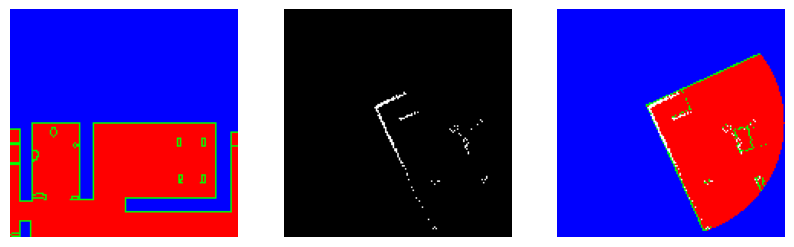

centre: [73.61391449 74.2096138 ], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [83.613914 33.209614] by 0.0, fpx_offset: [-0.3860855  0.2096138]
metadata: agent     @ [207.59177   36.816566] by 149.3921356201172
metadata: delta     @ [123.97785     3.6069527] by 149.3921356201172


<Figure size 1000x400 with 0 Axes>

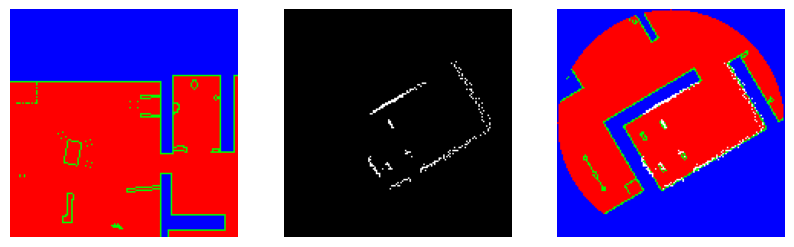

centre: [74.00678253 74.21487808], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [70.00678  40.214878] by 0.0, fpx_offset: [0.00678253 0.21487808]
metadata: agent     @ [247.4261    20.575056] by 112.04386901855469
metadata: delta     @ [177.41931  -19.639822] by 112.04386901855469


<Figure size 1000x400 with 0 Axes>

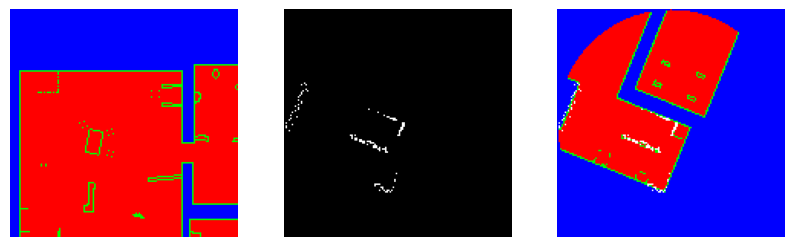

In [118]:
def show_data_sample(input_map, lds_map, output_map, adlo, metadata):
  dl = np.array([adlo[1], adlo[2]]) * 149
  do = np.rad2deg(adlo[3] * np.pi)

  sample_type = tf.cast(metadata[1], tf.int32)
  md_iml = np.array([metadata[2], metadata[3]]) / lds.__PIXEL_SIZE__
  md_imo = np.rad2deg(metadata[4])
  md_agl = np.array([metadata[5], metadata[6]]) / lds.__PIXEL_SIZE__
  md_ago = np.rad2deg(metadata[7])

  if sample_type == 0:
    fpx_offset = md_agl - np.round(md_agl)
  else:
    fpx_offset = md_iml - np.round(md_iml)

  lds_map = fix_lds(lds_map, adlo, fpx_offset)
  combined = tf.clip_by_value(output_map + lds_map[..., np.newaxis], 0.0, 1.0)

  plt.figure(figsize=(10,4))

  print(f"adlo:     delta     @ {dl} by {do}")
  print(f"metadata: input_map @ {md_iml} by {md_imo}, fpx_offset: {fpx_offset}")
  print(f"metadata: agent     @ {md_agl} by {md_ago}")
  print(f"metadata: delta     @ {md_agl - md_iml} by {md_ago - md_imo}")

  plt.figure(figsize=(10,4))

  plt.subplot(1,3,1)
  plt.imshow(input_map)
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(lds_map, cmap='gray')
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(combined)
  plt.axis('off')

  plt.show()

def show_dataset_alignment(dataset, num, sample_types):
    filtered = slam_data.filter_dataset(dataset, num, sample_types)
    for (input_map, lds_map), (output_map, adlo), metadata in filtered:
        show_data_sample(input_map, lds_map, output_map, adlo, metadata)


print("-- sample type 0 --")
show_dataset_alignment(train_data, 5, sample_types=0)
print("-- sample type 1 --")
show_dataset_alignment(train_data, 5, sample_types=1)
print("-- sample type 2 --")
print("(no output map to present)")
print("-- sample type 3 --")
show_dataset_alignment(train_data, 5, sample_types=3)

**Analysis**

Sample type 0 and 3:
* large visual misalignment between LDS map and expected output map


**Learnings:**

* The training dataset seems fine on most examples, but there are definitely the odd case here and there were there is a strong hint of an off-by-one error, with the semantic map tending to appear 1-px to the left of the LDS map, consistent with the errors induced by the model. This seems to be more evident for Sample Types 0 and 3, where the semantic map has been rotated (accounnting for 66% of samples).
* It's as if there's a sub-pixel miscalculation that ranges from 0.0 to 1.0px or so, and thus on the cases where it falls closer to 0.0px you don't see the error.
* It's a little hard to tell for certain with the noise in the LDS data. A strategy could be to re-run the data generation process with noise removed and to focus on just sample type 0.
* Another sanity check is to run the model against the base dataset and look for evidence of the shift there. For example, I could compare the actual vs expected output maps and look for shifts. I wouldn't expect to find one, but if it is there then that would be informative.

## Review Model against base Dataset



-- sample type 0 --
centre: [73.79629517 73.85287476], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.20370483 -0.14712524]
metadata: agent     @ [173.7963   116.852875] by 128.86041259765625
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

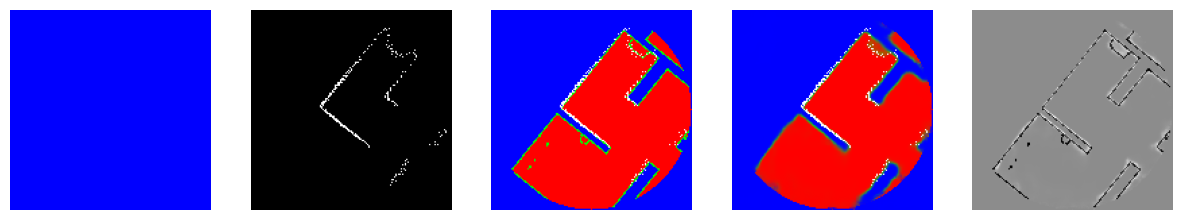

centre: [74.48204041 73.54418945], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [ 0.4820404  -0.45581055]
metadata: agent     @ [254.48204  36.54419] by 166.9495849609375
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

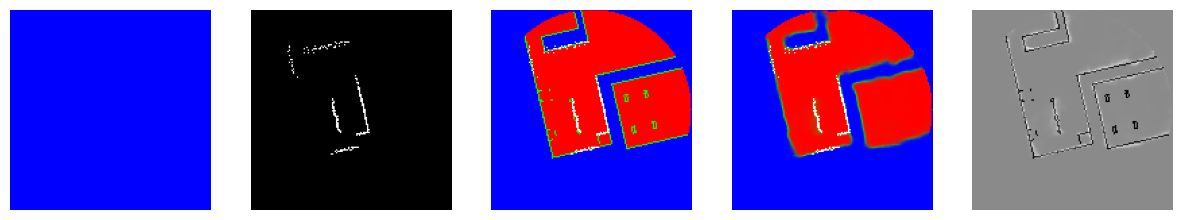

centre: [73.65704346 74.33798409], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.34295654  0.33798409]
metadata: agent     @ [205.65704   26.337984] by -63.01599884033203
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

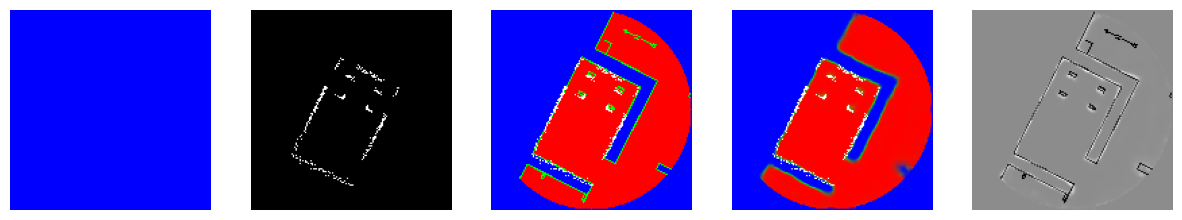

centre: [73.79417419 73.84069824], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.2058258  -0.15930176]
metadata: agent     @ [191.79417  46.8407 ] by -152.7494354248047
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

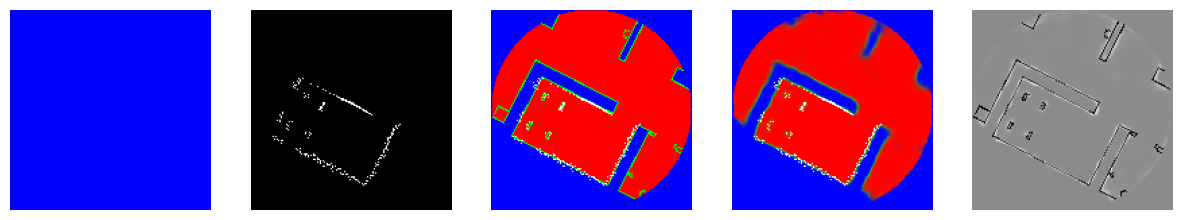

centre: [73.71668434 74.44444275], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.28331566  0.44444275]
metadata: agent     @ [29.716684 14.444443] by -129.13815307617188
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

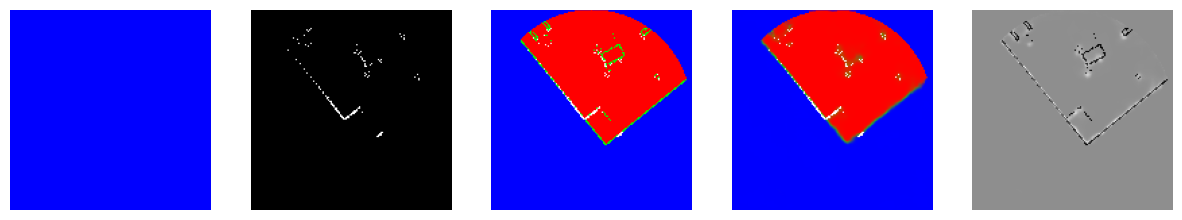

-- sample type 1 --
centre: [74.05664062 74.14541626], DL=[ -6.3431525 -13.211768 ], DO: 11.446252822875977
adlo:     delta     @ [ -6.3431525 -13.211768 ] by 11.446252822875977
metadata: input_map @ [ 69.05664 113.14542] by 0.0, fpx_offset: [0.05664062 0.14541626]
metadata: agent     @ [62.71349 99.93364] by -26.52892303466797
metadata: delta     @ [ -6.343151 -13.211777] by -26.52892303466797


<Figure size 1000x400 with 0 Axes>

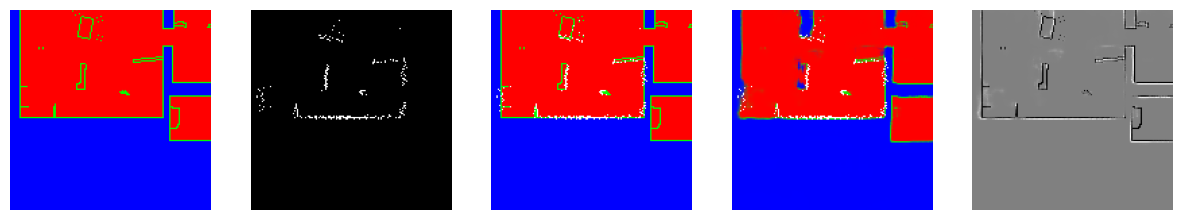

centre: [74.28509521 74.1027298 ], DL=[-0.06819189  3.0443778 ], DO: 7.860408306121826
adlo:     delta     @ [-0.06819189  3.0443778 ] by 7.860408306121826
metadata: input_map @ [250.2851   55.10273] by 0.0, fpx_offset: [0.2850952 0.1027298]
metadata: agent     @ [250.2169    58.147102] by -33.18524932861328
metadata: delta     @ [-0.06819153  3.0443726 ] by -33.18524932861328


<Figure size 1000x400 with 0 Axes>

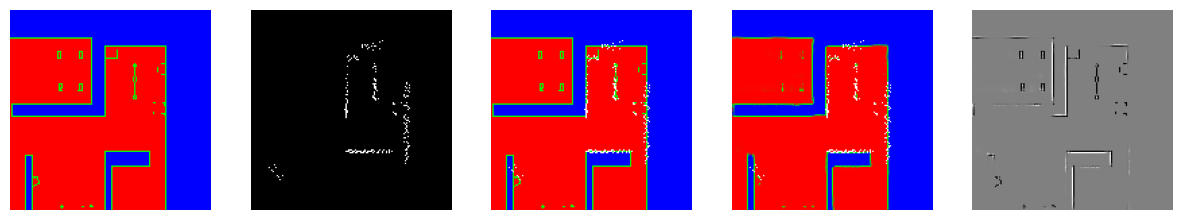

centre: [73.87966919 73.98262024], DL=[ -3.908571 -10.28917 ], DO: 5.280980110168457
adlo:     delta     @ [ -3.908571 -10.28917 ] by 5.280980110168457
metadata: input_map @ [221.87967 136.98262] by 0.0, fpx_offset: [-0.12033081 -0.01737976]
metadata: agent     @ [217.9711  126.69344] by 34.14410400390625
metadata: delta     @ [ -3.9085693 -10.289177 ] by 34.14410400390625


<Figure size 1000x400 with 0 Axes>

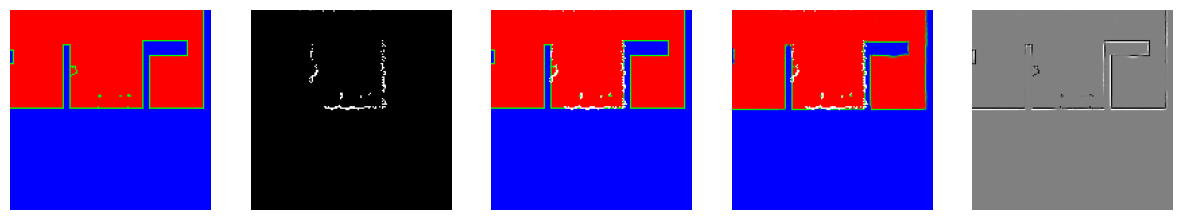

centre: [74.43919373 73.64788818], DL=[-2.3370569  -0.69479895], DO: 4.5558271408081055
adlo:     delta     @ [-2.3370569  -0.69479895] by 4.5558271408081055
metadata: input_map @ [ 32.439194 101.64789 ] by 0.0, fpx_offset: [ 0.43919373 -0.35211182]
metadata: agent     @ [ 30.102135 100.953094] by -101.95988464355469
metadata: delta     @ [-2.337059  -0.6947937] by -101.95988464355469


<Figure size 1000x400 with 0 Axes>

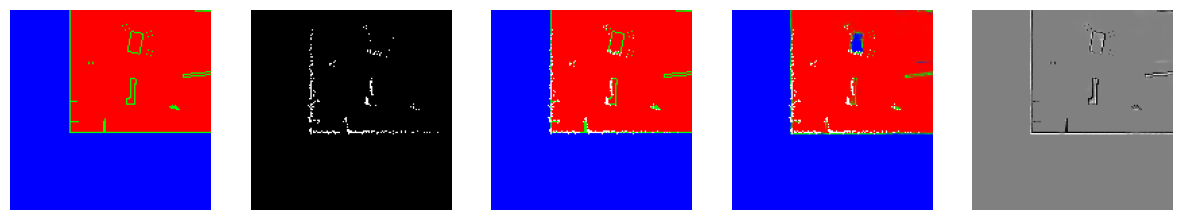

centre: [74.08421326 73.92869949], DL=[-4.119527    0.37853414], DO: 3.070713996887207
adlo:     delta     @ [-4.119527    0.37853414] by 3.070713996887207
metadata: input_map @ [228.08421  27.9287 ] by 0.0, fpx_offset: [ 0.08421326 -0.07130051]
metadata: agent     @ [223.96469   28.307232] by -37.958003997802734
metadata: delta     @ [-4.119522   0.3785324] by -37.958003997802734


<Figure size 1000x400 with 0 Axes>

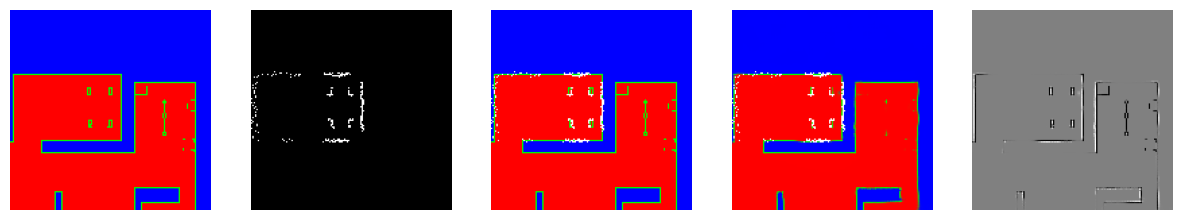

-- sample type 2 --
adlo:     delta     @ [  9.90941  -19.680294] by -56.75674057006836
metadata: input_map @ [277.8533    32.587044] by 0.0, fpx_offset: [-0.146698   -0.41295624]
metadata: agent     @ [287.7627    12.906751] by 130.84942626953125
metadata: delta     @ [  9.909393 -19.680294] by 130.84942626953125


<Figure size 1000x400 with 0 Axes>

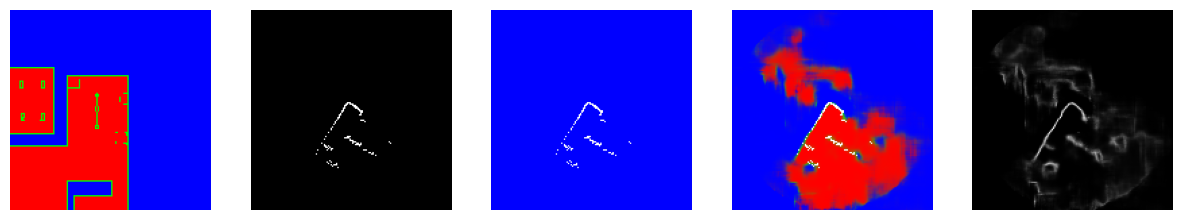

adlo:     delta     @ [13.04323 72.50247] by -13.06991195678711
metadata: input_map @ [120.001076  37.004982] by 0.0, fpx_offset: [0.00107574 0.00498199]
metadata: agent     @ [133.04431  109.507454] by 67.06832122802734
metadata: delta     @ [13.043236 72.50247 ] by 67.06832122802734


<Figure size 1000x400 with 0 Axes>

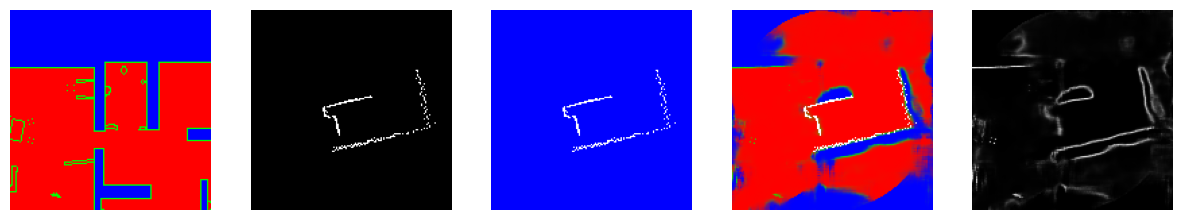

adlo:     delta     @ [  0.32458082 -19.187351  ] by 131.7184600830078
metadata: input_map @ [ 12.821351 103.88021 ] by 0.0, fpx_offset: [-0.17864895 -0.11978912]
metadata: agent     @ [13.145931 84.69286 ] by -59.88203430175781
metadata: delta     @ [  0.3245802 -19.187347 ] by -59.88203430175781


<Figure size 1000x400 with 0 Axes>

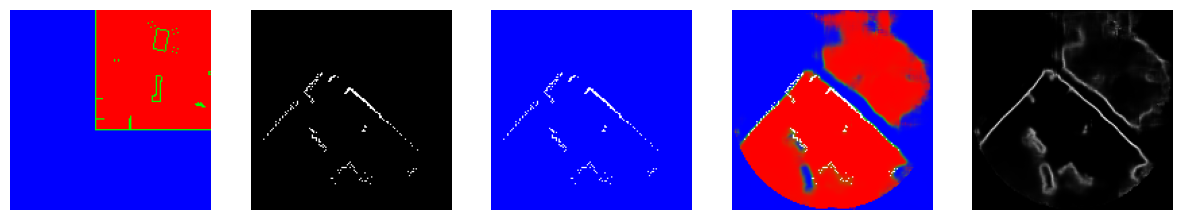

adlo:     delta     @ [-40.3909 -39.4088] by -117.48709106445312
metadata: input_map @ [294.41196  88.31548] by 0.0, fpx_offset: [0.4119568 0.3154831]
metadata: agent     @ [254.02104   48.906693] by -175.58096313476562
metadata: delta     @ [-40.390915 -39.40879 ] by -175.58096313476562


<Figure size 1000x400 with 0 Axes>

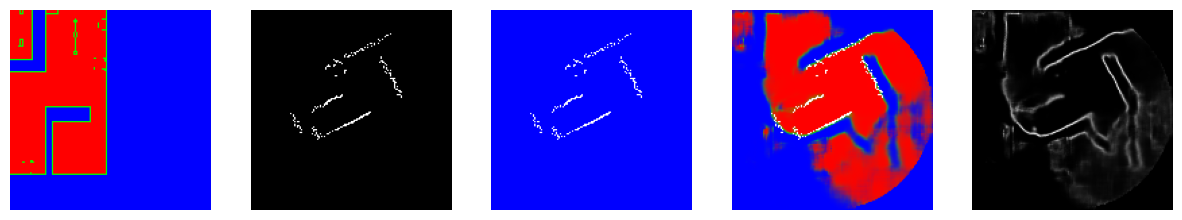

adlo:     delta     @ [-57.6663    42.541122] by 44.43235778808594
metadata: input_map @ [317.7387   -28.113773] by 0.0, fpx_offset: [-0.2612915  -0.11377335]
metadata: agent     @ [260.0724    14.427347] by -121.38842010498047
metadata: delta     @ [-57.66632   42.541122] by -121.38842010498047


<Figure size 1000x400 with 0 Axes>

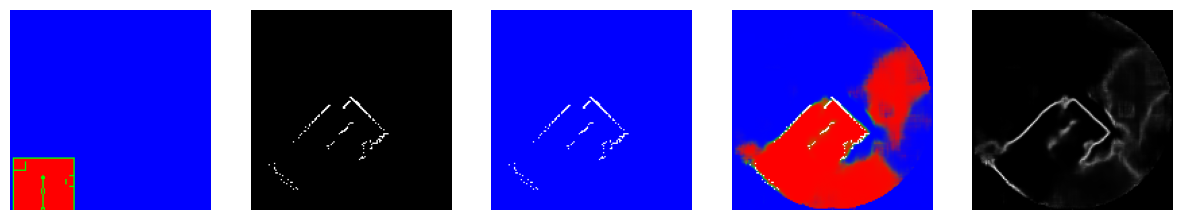

-- sample type 3 --
centre: [73.89830208 74.30261993], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [ 20.898302 113.30262 ] by 0.0, fpx_offset: [-0.10169792  0.30261993]
metadata: agent     @ [162.497  108.1064] by -170.71397399902344
metadata: delta     @ [141.5987     -5.1962204] by -170.71397399902344


<Figure size 1000x400 with 0 Axes>

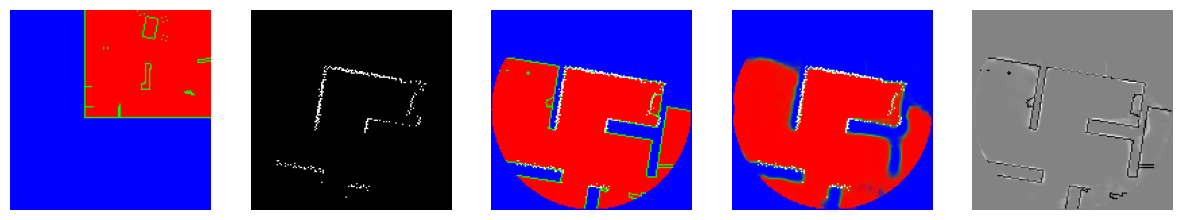

centre: [73.53901672 73.59795761], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [221.53902   60.597958] by 0.0, fpx_offset: [-0.46098328 -0.4020424 ]
metadata: agent     @ [17.337555 32.404034] by 42.59235763549805
metadata: delta     @ [-204.20146   -28.193924] by 42.59235763549805


<Figure size 1000x400 with 0 Axes>

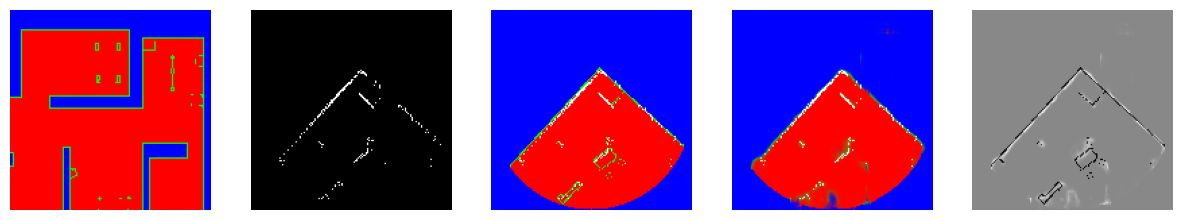

centre: [74.2043457  74.49439359], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [176.20435     2.4943936] by 0.0, fpx_offset: [0.2043457 0.4943936]
metadata: agent     @ [11.381504 22.324327] by -24.46354103088379
metadata: delta     @ [-164.82285    19.829933] by -24.46354103088379


<Figure size 1000x400 with 0 Axes>

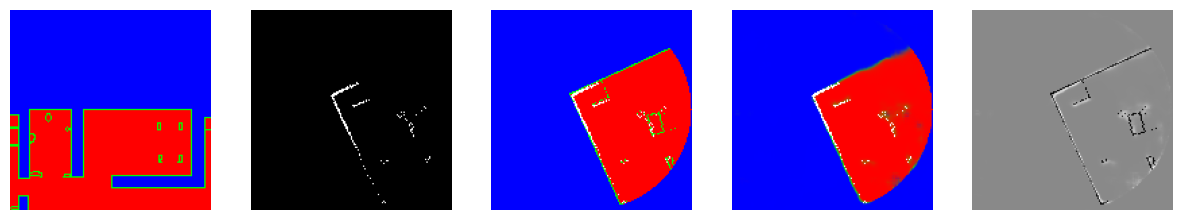

centre: [73.61391449 74.2096138 ], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [83.613914 33.209614] by 0.0, fpx_offset: [-0.3860855  0.2096138]
metadata: agent     @ [207.59177   36.816566] by 149.3921356201172
metadata: delta     @ [123.97785     3.6069527] by 149.3921356201172


<Figure size 1000x400 with 0 Axes>

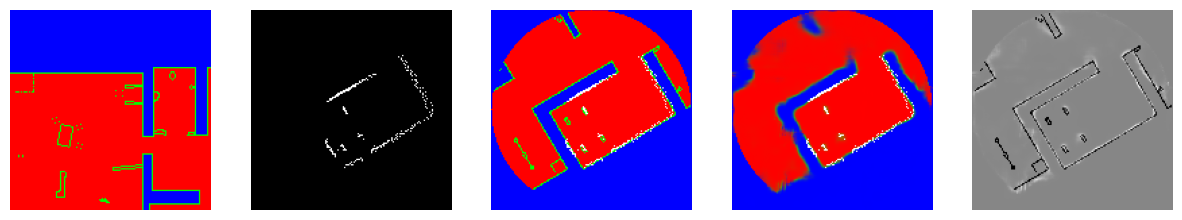

centre: [74.00678253 74.21487808], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [70.00678  40.214878] by 0.0, fpx_offset: [0.00678253 0.21487808]
metadata: agent     @ [247.4261    20.575056] by 112.04386901855469
metadata: delta     @ [177.41931  -19.639822] by 112.04386901855469


<Figure size 1000x400 with 0 Axes>

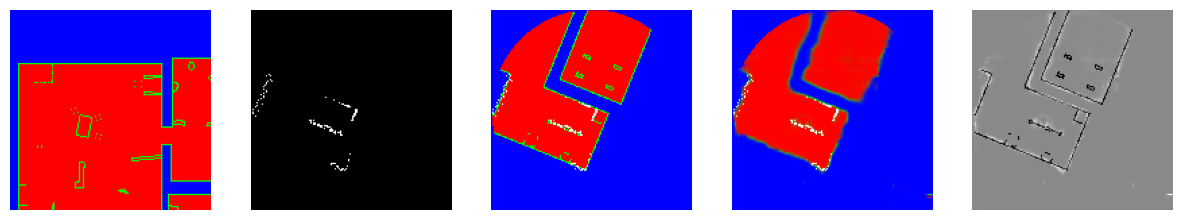

In [119]:
filtered = next(iter(filter_dataset(train_data, 1, sample_types=1)))
(input_map, lds_map), (output_map, adlo), metadata = filtered

def generate_effect(map_window, lds_map):
  np.random.seed(0)
  tf.random.set_seed(0)
  map_input = tf.expand_dims(map_window, axis=0)
  lds_input = tf.expand_dims(lds_map, axis=0)

  map_output, adlo_output = model.predict((map_input, lds_input), verbose=0)
  map_output = tf.math.softmax(map_output[0], axis=-1)

  #print(f"input_map:  {map_window.shape}")
  #print(f"lds_map:    {lds_map.shape} in range {np.min(lds_map)} - {np.max(lds_map)}")
  #print(f"output_map: {map_output.shape}")
  return map_output

def show_model_sample(input_map, lds_map, output_map, adlo, metadata):
  dl = np.array([adlo[1], adlo[2]]) * 149
  do = np.rad2deg(adlo[3] * np.pi)

  sample_type = tf.cast(metadata[1], tf.int32)
  md_iml = np.array([metadata[2], metadata[3]]) / lds.__PIXEL_SIZE__
  md_imo = np.rad2deg(metadata[4])
  md_agl = np.array([metadata[5], metadata[6]]) / lds.__PIXEL_SIZE__
  md_ago = np.rad2deg(metadata[7])
  if sample_type == 0:
    fpx_offset = md_agl - np.round(md_agl)
  else:
    fpx_offset = md_iml - np.round(md_iml)

  pred_output_map = generate_effect(input_map, lds_map)
  if sample_type != 2:
    lds_map = fix_lds(lds_map, adlo, fpx_offset)

  plt.figure(figsize=(10,4))

  print(f"adlo:     delta     @ {dl} by {do}")
  print(f"metadata: input_map @ {md_iml} by {md_imo}, fpx_offset: {fpx_offset}")
  print(f"metadata: agent     @ {md_agl} by {md_ago}")
  print(f"metadata: delta     @ {md_agl - md_iml} by {md_ago - md_imo}")

  plt.figure(figsize=(15,4))

  plt.subplot(1,5,1)
  plt.imshow(input_map)
  plt.axis('off')

  plt.subplot(1,5,2)
  plt.imshow(lds_map, cmap='gray')
  plt.axis('off')

  plt.subplot(1,5,3)
  plt.imshow(add_images(output_map, lds_map))
  plt.axis('off')

  plt.subplot(1,5,4)
  plt.imshow(add_images(pred_output_map, lds_map))
  plt.axis('off')

  plt.subplot(1,5,5)
  plt.imshow(diff_images(output_map, pred_output_map), cmap='gray')
  plt.axis('off')

  plt.show()

def show_model_alignment(dataset, num, sample_types):
    filtered = filter_dataset(dataset, num, sample_types)
    for (input_map, lds_map), (output_map, adlo), metadata in filtered:
        show_model_sample(input_map, lds_map, output_map, adlo, metadata)


print("-- sample type 0 --")
show_model_alignment(train_data, 5, sample_types=0)
print("-- sample type 1 --")
show_model_alignment(train_data, 5, sample_types=1)
print("-- sample type 2 --")
show_model_alignment(train_data, 5, sample_types=2)
print("-- sample type 3 --")
show_model_alignment(train_data, 5, sample_types=3)

## Data generation
It's become clear that I need to sanity check the sub-pixel logic within the core data generation.
To make that clearer, the simplest thing is to expand the resolution to 10x10px grids instead of a 1x1 grid. At that point the fpx_offset becomes more important.

Generating 1 samples of training data
Pixel size: 47.41
Max distance: 3500
Sample types: [1]
Mask output for sample types: (array([2]),)
Generating training data...
location_fpx: [177.75020549  88.97636579], location_px: [180  90], fpx_offset: [-2.24979451 -1.02363421]
Generated 1 samples after 1 attempts
adlo:     delta     @ [-16.899046   9.934914] by 11.626093864440918
metadata: input_map @ [177.75021  88.97637] by 0.0, fpx_offset: [-0.24978638 -0.02362823]
metadata: agent     @ [160.85117  98.91128] by 36.99481201171875
metadata: delta     @ [-16.899048   9.934906] by 36.99481201171875


<Figure size 1000x400 with 0 Axes>

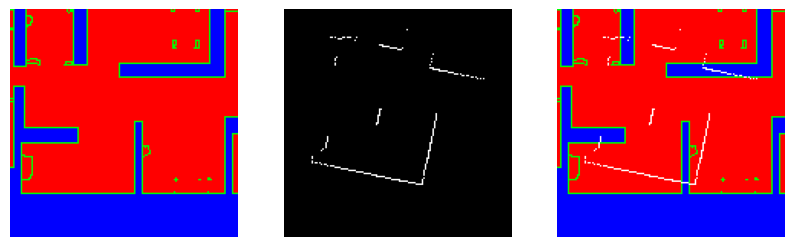

In [185]:
reload(slam_data)

# using modified data-generation methods that don't add noise, making it easier to align the results
def generate_training_data(semantic_map, num_samples=5, **kwargs):
    tot_sample_types = 4
    pixel_size = kwargs.get('pixel_size', lds.__PIXEL_SIZE__)
    max_distance = kwargs.get('max_distance', lds.__MAX_DISTANCE__)
    enable_noise = kwargs.get('enable_noise', True)
    enable_errors = kwargs.get('enable_errors', True)
    sample_types = np.array(kwargs.get('sample_types', range(tot_sample_types)))
    sample_types = np.ravel(np.array(sample_types))  # cleanup type variations
    mask_output_map_by_sample_type = np.array(kwargs.get('mask_output_map_by_sample_type', [False, False, True, False]))
    model = kwargs.get('model', None)
    model_weight = kwargs.get('model_weight', 1.0 if model is not None else 0.0)
    print(f"Generating {num_samples} samples of training data")
    print(f"Pixel size: {pixel_size}")
    print(f"Max distance: {max_distance}")
    print(f"Sample types: {sample_types}")
    if np.sum(mask_output_map_by_sample_type) == 0:
        print(f"Mask output for sample types: None")
    else:
        print(f"Mask output for sample types: {np.where(mask_output_map_by_sample_type)}")

    # identify ranges
    # - size of full map (W, H), physical units
    # - size of window (W, H), physical units
    map_range_low, map_range_high = slam_data.get_location_range(semantic_map, **kwargs)
    window_size = (np.ceil(max_distance / pixel_size).astype(int) * 2 + 1) * pixel_size
    window_range = np.array([window_size, window_size])

    # do data generation
    print("Generating training data...")
    input_maps = []
    lds_maps = []
    output_maps = []
    adlos = []
    metadatas = []
    attempts = 0
    for _ in range(num_samples):
        # keep trying until we generate one sample
        while True:
            attempts += 1
            sample_type = np.random.choice(sample_types)
            gen_output_map = not mask_output_map_by_sample_type[sample_type]
            accept = True
            loc_error = (0.0, 0.0)
            angle_error = 0.0

            # Agent true location: on floor
            # - facing any angle
            agent_location = slam_data.random_floor_location(semantic_map, map_range_low, map_range_high)
            agent_angle = np.random.uniform(-np.pi, np.pi)

            if sample_type == 0:
                # New map, unknown location and orientation, loc/angle error disregarded
                # - blank input map, populated LDS map
                # - populated output map, A=accept, DLO=zeros

                # Map location = Estimated location: unknown
                map_location, map_angle = None, None

                input_map, lds_map, output_map, _ = generate_training_data_sample(
                    semantic_map, agent_location, agent_angle, False, gen_output_map, None, None, **kwargs)

            elif sample_type == 1:
                # Known map, known location/angle estimation with small normal error
                # - populated input map, populated LDS map
                # - populated output map, A=accept, DLO=accurate low non-zero

                # Map location = Estimated location: small normal error from agent location
                # - allowed to be an illegal position
                # - loc_error - normal about centre, std.dev = 10% of range
                # - angle_error - normal about zero, std.dev = 10% of 180 degrees
                if enable_errors:
                  loc_error = np.random.normal((0, 0), window_range / 2 * 0.1)
                  angle_error = np.random.uniform(0, np.pi * 0.1)
                else:
                  loc_error = np.array([0., 0.])
                  angle_error = 0
                loc_error = np.clip(loc_error, -window_range / 2, +window_range / 2)
                angle_error = np.clip(angle_error, -np.pi, +np.pi)
                map_location = agent_location - loc_error
                map_angle = agent_angle - angle_error

                input_map, lds_map, output_map, _ = generate_training_data_sample(
                    semantic_map, map_location, map_angle, True, gen_output_map, loc_error, angle_error, **kwargs)

            elif sample_type == 2:
                # Known map, location unknown and searching, with LDS data partially on this map window.
                # - populated input map, populated LDS map
                # - populated or blank output map, A=accept, DLO=approximate high non-zero

                # Map location: independent uniform random location WITHIN window distance
                # - allowed to be in illegal position
                # - loc_error - uniform either side of zero, anywhere within window
                # - angle_error - uniform anywhere within 360-degree range
                if enable_errors:
                  loc_error = np.random.uniform(-window_range / 2, +window_range / 2)
                  angle_error = np.random.uniform(-np.pi, np.pi)
                else:
                  loc_error = np.array([0., 0.])
                  angle_error = 0
                map_location = agent_location - loc_error
                map_angle = agent_angle - angle_error

                input_map, lds_map, output_map, _ = generate_training_data_sample(
                    semantic_map, map_location, map_angle, True, gen_output_map, loc_error, angle_error, **kwargs)

            elif sample_type == 3:
                # Known map, location unknown and searching, with LDS not on this map window.
                # LDS and map explicitly in different parts of the floor (max 1/4th overlap between LDS circles)
                # - populated input map, populated LDS map
                # - populated or blank output map, A=reject, DLO=zero, but don't care

                # Map location: independent uniform random location OUTSIDE window distance
                # - allowed to be in illegal position
                # - location - at most only 1/4th of diameter of LDS circles will overlap
                # - angle - uniform anywhere within 360-degree range
                min_distance = max_distance * 1.5
                map_location = None
                while map_location is None or np.linalg.norm(map_location - agent_location) < min_distance:
                    map_location = np.random.uniform(map_range_low, map_range_high)
                map_angle = np.random.uniform(-np.pi, np.pi)
                loc_error = agent_location - map_location
                angle_error = agent_angle - map_angle

                input_map, _, _, _ = generate_training_data_sample(
                    semantic_map, map_location, map_angle, True, False, loc_error, angle_error, **kwargs)
                _, lds_map, output_map, _ = generate_training_data_sample(
                    semantic_map, agent_location, agent_angle, False, gen_output_map, None, None, **kwargs)

                # for expected NN outputs
                # (error should be ignored by loss function, but if we do let it train on these values then we'd
                #  prefer the NN doesn't claim there's a loc error)
                accept = False
                loc_error = (0, 0)
                angle_error = 0

            else:
                raise ValueError(f"unrecognised sample_type: {sample_type}")
            if tot_sample_types < (3 + 1):
                raise ValueError("tot_sample_types needs revising: {tot_sample_types}")

            # emit result
            if lds_map is not None:
                adlo = np.array([
                    1.0 if accept else 0.0,
                    loc_error[0] / window_range[0],  # convert to range: -0.5 .. +0.5
                    loc_error[1] / window_range[1],  # convert to range: -0.5 .. +0.5
                    angle_error / np.pi  # convert to range: -1.0 .. +1.0
                ])
                metadata = np.array([
                    2.0,  # always static floorplan Id for now
                    sample_type,
                    map_location[0] if map_location is not None else np.nan,
                    map_location[1] if map_location is not None else np.nan,
                    0.0 if map_angle is not None else np.nan,  # map always at 0-degrees
                    agent_location[0],
                    agent_location[1],
                    agent_angle
                ])
                input_maps.append(input_map)
                lds_maps.append(lds_map)
                output_maps.append(output_map)
                adlos.append(adlo.astype(np.float32))
                metadatas.append(metadata.astype(np.float32))
                break

    print(f"Generated {len(input_maps)} samples after {attempts} attempts")
    return tf.data.Dataset.from_tensor_slices((
        (input_maps, lds_maps),
        (output_maps, adlos),
        metadatas
    ))

def generate_training_data_sample(semantic_map, location, orientation, map_known, gen_output_map, location_error,
                                  orientation_error, **kwargs):
    # config
    default_unknown_value = np.zeros(slam_data.__CLASSES__, dtype=semantic_map.dtype)
    default_unknown_value[slam_data.__UNKNOWN_IDX__] = 1

    max_distance = kwargs.get('max_distance', lds.__MAX_DISTANCE__)
    pixel_size = kwargs.get('pixel_size', lds.__PIXEL_SIZE__)
    unknown_value = kwargs.get('unknown_value', default_unknown_value)
    grid = kwargs.get('grid', 1)

    location_error = np.array(location_error) if location_error is not None else np.array([0.0, 0.0])
    orientation_error = orientation_error if orientation_error is not None else 0.0
    window_size_px = np.ceil(max_distance / pixel_size).astype(int) * 2 + 1
    window_size_px = np.array([window_size_px, window_size_px])

    # take LDS sample
    lds_orientation = (orientation + orientation_error) if np.isfinite(orientation_error) else orientation
    ranges = lds.lds_sample(semantic_map[:, :, slam_data.__OBSTRUCTION_IDX__], location + location_error,
                            lds_orientation, **kwargs)
    if (np.nanmax(ranges) < pixel_size) or ranges[~np.isnan(ranges)].size == 0:
        return None, None, None, None

    # generate input map
    # (aligned to map pixels and zero rotation)
    location_fpx = location / pixel_size  # sub-pixel resolution ("float pixels")
    location_px = (np.round(location_fpx/grid) * grid).astype(int)
    location_alignment_offset_fpx = location_fpx - location_px  # true centre relative to window centre
    print(f"location_fpx: {location_fpx}, location_px: {location_px}, fpx_offset: {location_alignment_offset_fpx}")
    if map_known:
        # crop from original floorplan
        input_map = rotated_crop(
            semantic_map, location_px, 0.0, size=window_size_px, mask='none', pad_value=unknown_value)
    else:
        # all unknown
        input_map = slam_data.unknown_map(window_size_px, unknown_value=unknown_value)

    # generate output map
    if not gen_output_map:
        # don't care: blank map
        output_map = slam_data.unknown_map(window_size_px, unknown_value=unknown_value)
    elif map_known:
        # map location known: align to map pixels and zero rotation
        output_map = rotated_crop(
            semantic_map, location_px, 0.0, size=window_size_px, mask='none', pad_value=unknown_value)
    else:
        # map location unknown: align to exact centre of window and agent's ground truth orientation
        output_map = rotated_crop(
            semantic_map, location_fpx, orientation, size=window_size_px, mask='inner-circle', pad_value=unknown_value, interpolation=cv2.INTER_AREA)
        location_alignment_offset_fpx = (0, 0)

    # generate LDS semantic map
    # (oriented according to agent's believed orientation, which omits the orientation_error,
    #  and is 0.0 if completely unknown)
    believed_orientation = orientation if map_known and np.isfinite(orientation_error) else 0.0
    lds_map = lds.lds_to_occupancy_map(
        ranges, angle=believed_orientation, size_px=window_size_px, centre_px=location_alignment_offset_fpx,
        pixel_size=pixel_size)

    return input_map, lds_map, output_map, location_alignment_offset_fpx

def show_data_sample(input_map, lds_map, output_map, adlo, metadata, **kwargs):
  remove_errors = kwargs.get('remove_errors', False)

  dl = np.array([adlo[1], adlo[2]]) * 149
  do = np.rad2deg(adlo[3] * np.pi)

  sample_type = tf.cast(metadata[1], tf.int32)
  md_iml = np.array([metadata[2], metadata[3]]) / lds.__PIXEL_SIZE__
  md_imo = np.rad2deg(metadata[4])
  md_agl = np.array([metadata[5], metadata[6]]) / lds.__PIXEL_SIZE__
  md_ago = np.rad2deg(metadata[7])

  if sample_type == 0:
    fpx_offset = md_agl - np.round(md_agl)
  else:
    fpx_offset = md_iml - np.round(md_iml)
    if remove_errors:
      lds_map = fix_lds(lds_map, adlo, fpx_offset)

  plt.figure(figsize=(10,4))

  print(f"adlo:     delta     @ {dl} by {do}")
  print(f"metadata: input_map @ {md_iml} by {md_imo}, fpx_offset: {fpx_offset}")
  print(f"metadata: agent     @ {md_agl} by {md_ago}")
  print(f"metadata: delta     @ {md_agl - md_iml} by {md_ago - md_imo}")

  plt.figure(figsize=(10,4))

  plt.subplot(1,3,1)
  plt.imshow(input_map)
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(lds_map, cmap='gray')
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(add_images(output_map, lds_map))
  plt.axis('off')

  plt.show()

def show_dataset_alignment(dataset, num=10, sample_types=None, **kwargs):
    filtered = slam_data.filter_dataset(dataset, num, sample_types)
    for (input_map, lds_map), (output_map, adlo), metadata in filtered:
        show_data_sample(input_map, lds_map, output_map, adlo, metadata, **kwargs)

tf.random.set_seed(0)
np.random.seed(0)
dataset = generate_training_data(floorplan, num_samples=1, sample_types=1, enable_errors=True, noise_ranges=None, grid=15)
#slam_data.show_dataset(dataset)
show_dataset_alignment(dataset, remove_errors=False)

**Learnings (before applying fixes):**
* Definitely had a bug for Sample Types 0 and 3 with fpx_offset being inappropriate used when rotating LDS maps.
* for Sample Types 0 and 3, there's also an off-by-0.5px error in map_from_lds_train_data.rotated_crop(). I get perfect alignment if I shift the rotation centre by (+0.5, +0.5). Need to investigate and figure that one out.
* For Sample Types 0 and 3, it's also interesting to use `cv2.INTER_AREA` or `cv2.INTER_LINEAR` interpolation when rotating. This produces much nicer, smoother, and probably more realistic expected semantic maps with smoother lines. The only problem is that it performs anti-aliasing and thus it's no longer feeding the loss function discrete categories. From past bad experiences, I'm concerned how that will affect the loss computations.
* Sample Type 1 seems to align the LDS map and output map correctly, even when using a grid-size of 15.
* Sample Type 1 looks to have a problem with its location_error being way too large.

**Fixes**

The following fixes were applied:
* The fpx_offset bug for Sample Types 0 and 3 was fixed by using raw fpx for the LDS map centre when likewise doing for the semantic map rotation
* The semantic map rotation code had some inaccuracies when using sub-pixel resolution centres. The most important fix was to apply a sub-pixel resolution translation of the semantic map _before_ cropping. This shifted it to align to the target crop. Previously I was hacking the crop to align to the semantic map, which led to an up to +/- 0.5 pixel offset.
* Additionally I improved the padding logic so that the rotated_crop function can be used with interpolation and still produce clean results. Previously it was sometimes producing thin near-black lines where the padding values didn't get applied. My solution isn't quite complete, but it seems to be working for all data samples I've seen.

**Learnings (post fixes)**
* The LDS maps now align perfectly to the semantic maps.
* Any remaining inaccuracies there are due to the odd way that I generate the LDS range data from pixel sources. But I'm hoping that won't be a problem because a) it should be symmetric for all directions and thus will get averaged out, and b) LDS data gets much larger noise values added anyway.
* There's still a possibility with the LDS quirks creating a kind of shifting force that pushes either outwards or inwards relative to the centre, so that walls then tend to shift outwards or inwards relative to the centre.
* I can't see any problems with Sample Type 1 errors being too large.

It's interesting to note that the most obvious problems found so far are _not_ for the scenario (Sample Type 1) that causes the map shift problems in my animations.

I think the best thing to do now is to retrain with the improved dataset, and go from there.

## Final Checks
Now use latest dataset generation and verify the results.

Generating 50 samples of training data
Input maps: using floorplan samples only
Pixel size: 47.41
Max distance: 3500
Sample types: [0 1 2 3]
Mask output for sample types: (array([2]),)
Generating training data...


100%|██████████| 50/50 [00:03<00:00, 12.74it/s]


Generated 50 samples after 50 attempts
-- sample type 0 --
centre: [74.35821533 73.78672791], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [ 0.35821533 -0.2132721 ]
metadata: agent     @ [145.35822 103.78673] by 78.52139282226562
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

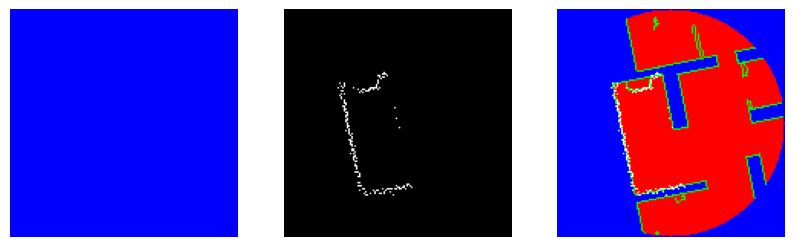

centre: [73.85975647 74.17966461], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.14024353  0.17966461]
metadata: agent     @ [117.85976   52.179665] by 114.20118713378906
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

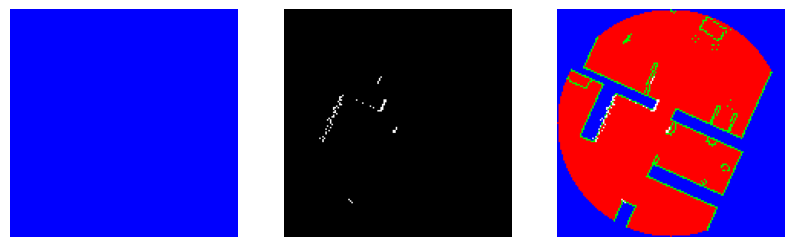

centre: [73.6368103  73.82440186], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [-0.3631897  -0.17559814]
metadata: agent     @ [194.63681  71.8244 ] by 39.996368408203125
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

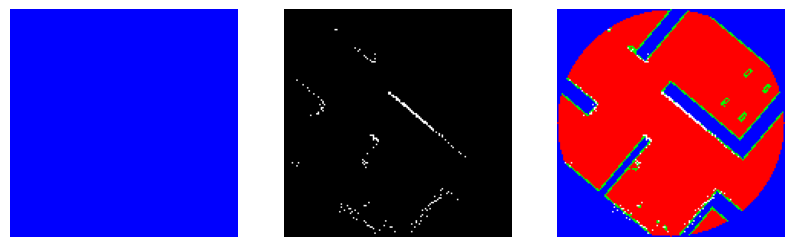

centre: [74.01557255 73.913414  ], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [ 0.01557255 -0.086586  ]
metadata: agent     @ [ 6.0155725 46.913414 ] by -84.49239349365234
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

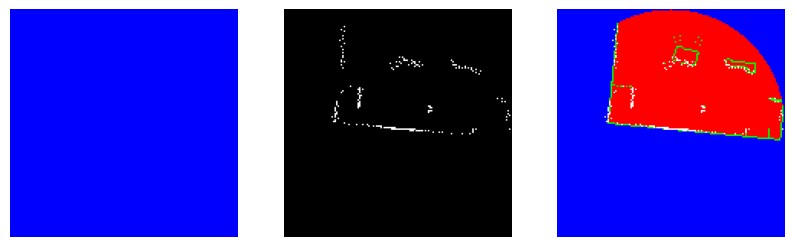

centre: [74.3894043  73.50805664], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [nan nan] by nan, fpx_offset: [ 0.3894043  -0.49194336]
metadata: agent     @ [286.3894  112.50806] by 2.0799243450164795
metadata: delta     @ [nan nan] by nan


<Figure size 1000x400 with 0 Axes>

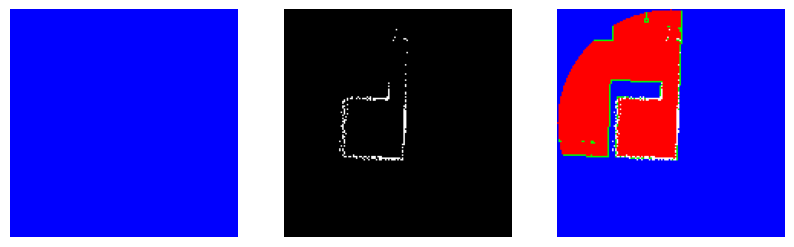

-- sample type 1 --
centre: [73.88172722 74.41496277], DL=[ 12.723017 -10.543867], DO: 1.3388142585754395
adlo:     delta     @ [ 12.723017 -10.543867] by 1.3388142585754395
metadata: input_map @ [ 19.881727 118.41496 ] by 0.0, fpx_offset: [-0.11827278  0.41496277]
metadata: agent     @ [ 32.604748 107.8711  ] by -134.54554748535156
metadata: delta     @ [ 12.723021 -10.543861] by -134.54554748535156


<Figure size 1000x400 with 0 Axes>

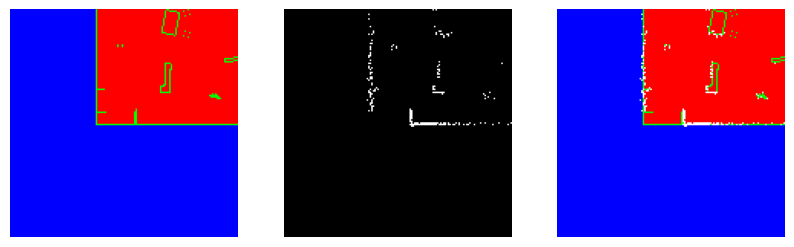

centre: [74.12525749 73.65841484], DL=[5.5549793 0.3541578], DO: 10.458467483520508
adlo:     delta     @ [5.5549793 0.3541578] by 10.458467483520508
metadata: input_map @ [16.125257 26.658415] by 0.0, fpx_offset: [ 0.12525749 -0.34158516]
metadata: agent     @ [21.680237 27.012573] by -177.68658447265625
metadata: delta     @ [5.5549793 0.3541584] by -177.68658447265625


<Figure size 1000x400 with 0 Axes>

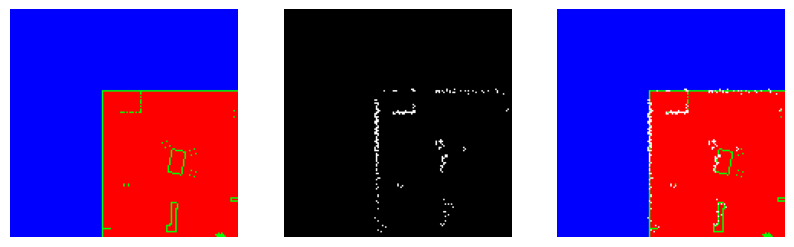

centre: [73.95976257 74.24423981], DL=[2.1818826 7.183497 ], DO: 6.007807731628418
adlo:     delta     @ [2.1818826 7.183497 ] by 6.007807731628418
metadata: input_map @ [87.95976 87.24424] by 0.0, fpx_offset: [-0.04023743  0.2442398 ]
metadata: agent     @ [90.14164  94.427734] by -130.85301208496094
metadata: delta     @ [2.1818771 7.1834946] by -130.85301208496094


<Figure size 1000x400 with 0 Axes>

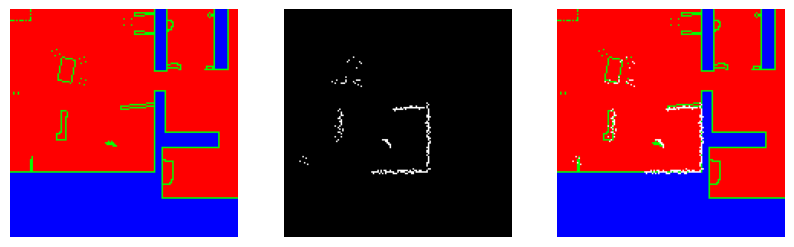

centre: [74.17355347 74.2374382 ], DL=[-9.830993 -3.503703], DO: 15.30640697479248
adlo:     delta     @ [-9.830993 -3.503703] by 15.30640697479248
metadata: input_map @ [150.17355  63.23744] by 0.0, fpx_offset: [0.17355347 0.2374382 ]
metadata: agent     @ [140.34256   59.733734] by -94.07245635986328
metadata: delta     @ [-9.830994 -3.503704] by -94.07245635986328


<Figure size 1000x400 with 0 Axes>

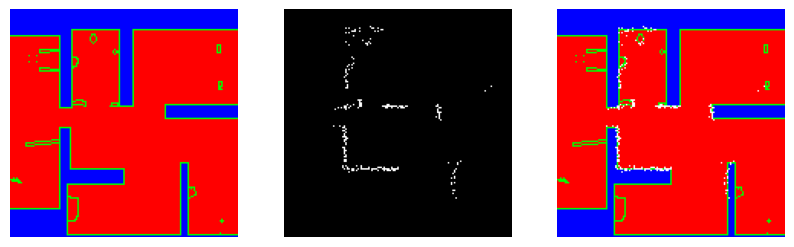

centre: [74.08750916 73.64823151], DL=[2.0888414 1.0671728], DO: 13.526459693908691
adlo:     delta     @ [2.0888414 1.0671728] by 13.526459693908691
metadata: input_map @ [96.08751 47.64823] by 0.0, fpx_offset: [ 0.08750916 -0.3517685 ]
metadata: agent     @ [98.17635 48.71541] by -31.2196044921875
metadata: delta     @ [2.0888443 1.0671768] by -31.2196044921875


<Figure size 1000x400 with 0 Axes>

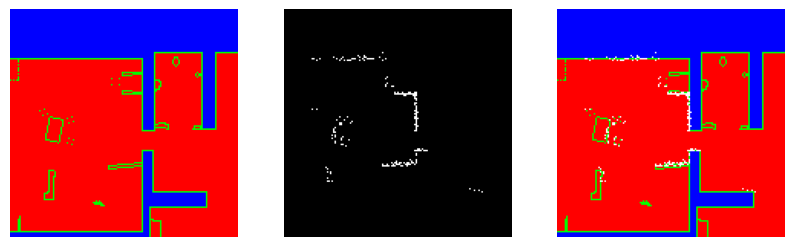

-- sample type 2 --
(no output map to present)
-- sample type 3 --
centre: [74.27430725 73.94361115], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [109.27431 115.94361] by 0.0, fpx_offset: [ 0.27430725 -0.05638885]
metadata: agent     @ [11.444295 47.26019 ] by -135.4125518798828
metadata: delta     @ [-97.83001  -68.683426] by -135.4125518798828


<Figure size 1000x400 with 0 Axes>

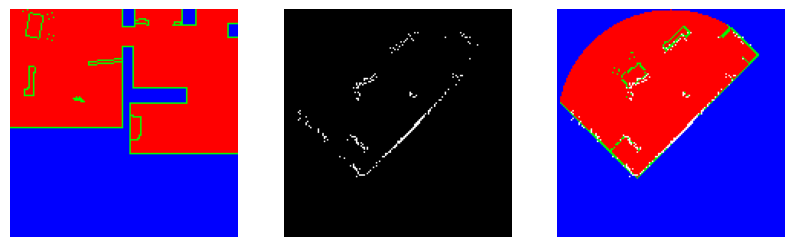

centre: [74.40333557 73.59066391], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [136.40334   44.590664] by 0.0, fpx_offset: [ 0.40333557 -0.4093361 ]
metadata: agent     @ [288.7795   75.00107] by -161.01292419433594
metadata: delta     @ [152.37617   30.410404] by -161.01292419433594


<Figure size 1000x400 with 0 Axes>

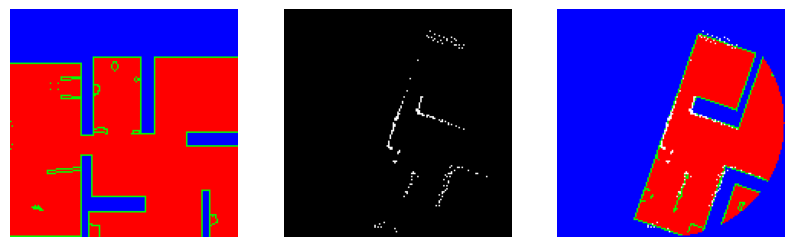

centre: [74.14134979 74.08058548], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [37.14135  41.080585] by 0.0, fpx_offset: [0.14134979 0.08058548]
metadata: agent     @ [210.03075   22.449907] by 112.22845458984375
metadata: delta     @ [172.8894   -18.630678] by 112.22845458984375


<Figure size 1000x400 with 0 Axes>

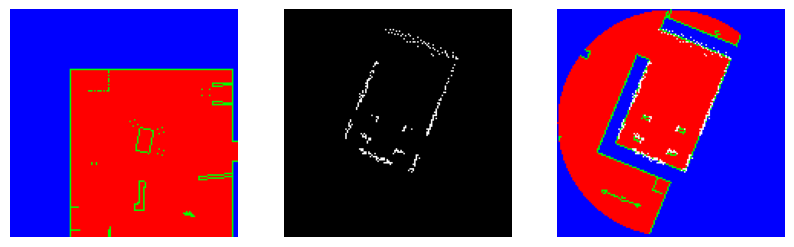

centre: [74.21180725 74.31349182], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [255.2118  131.31349] by 0.0, fpx_offset: [0.21180725 0.31349182]
metadata: agent     @ [142.18863  72.92183] by -69.29096984863281
metadata: delta     @ [-113.02318   -58.391663] by -69.29096984863281


<Figure size 1000x400 with 0 Axes>

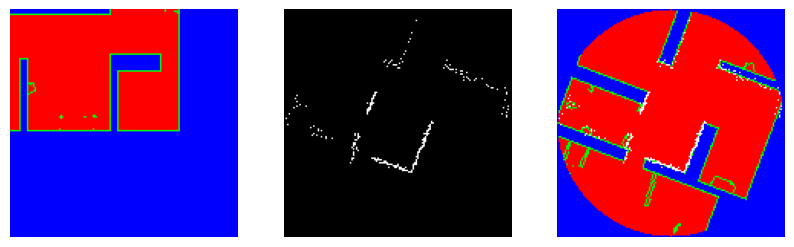

centre: [74.48244476 73.85123062], DL=[0. 0.], DO: 0.0
adlo:     delta     @ [0. 0.] by 0.0
metadata: input_map @ [60.482445 46.85123 ] by 0.0, fpx_offset: [ 0.48244476 -0.14876938]
metadata: agent     @ [211.11774    9.423235] by 75.34468078613281
metadata: delta     @ [150.63528  -37.427994] by 75.34468078613281


<Figure size 1000x400 with 0 Axes>

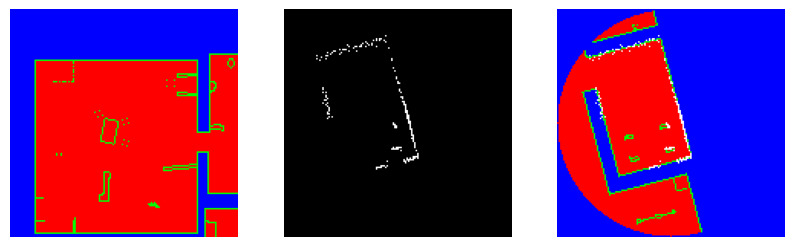

In [188]:
def show_data_sample(input_map, lds_map, output_map, adlo, metadata):
  dl = np.array([adlo[1], adlo[2]]) * 149
  do = np.rad2deg(adlo[3] * np.pi)

  sample_type = tf.cast(metadata[1], tf.int32)
  md_iml = np.array([metadata[2], metadata[3]]) / lds.__PIXEL_SIZE__
  md_imo = np.rad2deg(metadata[4])
  md_agl = np.array([metadata[5], metadata[6]]) / lds.__PIXEL_SIZE__
  md_ago = np.rad2deg(metadata[7])

  if sample_type == 0:
    fpx_offset = md_agl - np.round(md_agl)
  else:
    fpx_offset = md_iml - np.round(md_iml)

  lds_map = fix_lds(lds_map, adlo, fpx_offset)
  combined = tf.clip_by_value(output_map + lds_map[..., np.newaxis], 0.0, 1.0)

  plt.figure(figsize=(10,4))

  print(f"adlo:     delta     @ {dl} by {do}")
  print(f"metadata: input_map @ {md_iml} by {md_imo}, fpx_offset: {fpx_offset}")
  print(f"metadata: agent     @ {md_agl} by {md_ago}")
  print(f"metadata: delta     @ {md_agl - md_iml} by {md_ago - md_imo}")

  plt.figure(figsize=(10,4))

  plt.subplot(1,3,1)
  plt.imshow(input_map)
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(lds_map, cmap='gray')
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(combined)
  plt.axis('off')

  plt.show()

def show_dataset_alignment(dataset, num, sample_types):
    filtered = slam_data.filter_dataset(dataset, num, sample_types)
    for (input_map, lds_map), (output_map, adlo), metadata in filtered:
        show_data_sample(input_map, lds_map, output_map, adlo, metadata)

dataset = slam_data.generate_training_data(floorplan, num_samples=50)

print("-- sample type 0 --")
show_dataset_alignment(dataset, 5, sample_types=0)
print("-- sample type 1 --")
show_dataset_alignment(dataset, 5, sample_types=1)
print("-- sample type 2 --")
print("(no output map to present)")
print("-- sample type 3 --")
show_dataset_alignment(dataset, 5, sample_types=3)

**Looks good!**

## Appendix: LDS Rotation and Translation

centre: [74. 74.], DL=[ -6.3431525 -13.211768 ], DO: 11.446252822875977


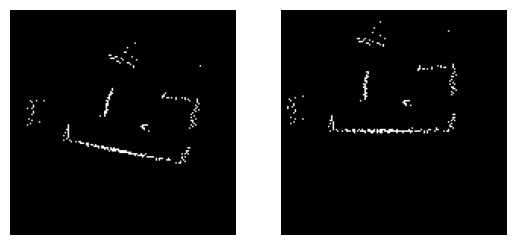

In [79]:
filtered = next(iter(slam_data.filter_dataset(train_data, 1, sample_types=1)))
(input_map, lds_map), (output_map, adlo), metadata = filtered

def fix_lds(lds_map, adlo):
  dl = np.array([adlo[1], adlo[2]]) * 149
  do = adlo[3] * np.pi

  centre = (np.array([149, 149])-1) / 2.0
  print(f"centre: {centre}, DL={dl}, DO: {np.rad2deg(do)}")
  affine = cv2.getRotationMatrix2D(centre, np.rad2deg(do), scale=1.0)
  affine[0, 2] += dl[0]
  affine[1, 2] += dl[1]
  return cv2.warpAffine(lds_map.numpy(), affine, (149, 149), flags=cv2.INTER_NEAREST)

transformed = fix_lds(lds_map, adlo)

plt.subplot(1,2,1)
plt.imshow(lds_map, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(transformed, cmap='gray')
plt.axis('off')

plt.show()

## Appendix: Image Rotation
There appears to be a (+0.5, +0.5) offset in map_from_lds_train_data.rotated_crop(), so let's focus on that and write some unit tests for it while we're at it.

In [130]:
reload(slam_data)
reload(slam_data_test)
slam_data_test.run_test_suite()

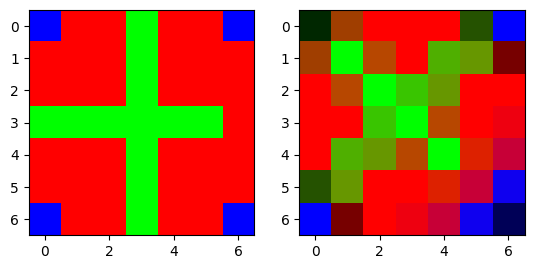

In [152]:
reload(slam_data)
from slam_data import rotated_crop

def test_image_at_90(angle):
    g = np.array([
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
    ])
    b = np.array([
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
    ])
    # add non-symmetry
    if angle == 0:
        g[3, 6] = 0
    elif angle == 90:
        g[0, 3] = 0
    elif angle == 180:
        g[3, 0] = 0
    elif angle == -90:
        g[6, 3] = 0
    else:
        raise ValueError(angle)
    r = np.ones_like(g) - g - b
    return np.dstack((r, g, b))


img = test_image_at_90(0)
out = rotated_crop(img, (3.4, 3), np.deg2rad(45), size=(7,7), mask='none', pad_value=(0,0,1), interpolation=cv2.INTER_AREA)

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(out)
plt.show()


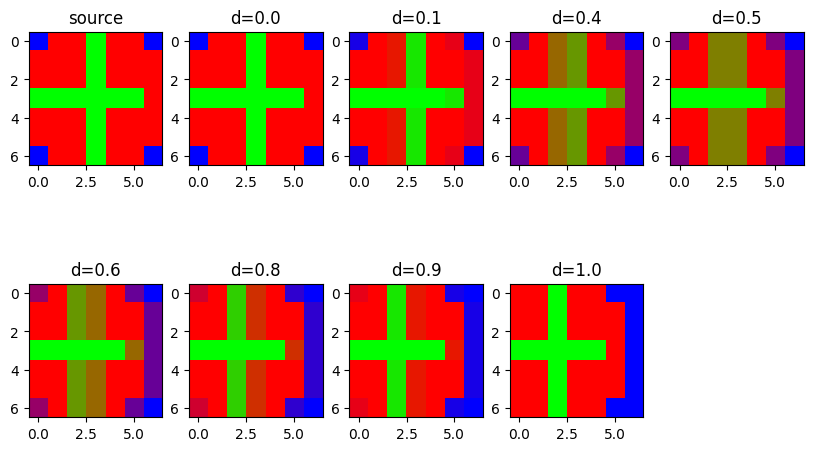

In [153]:
reload(slam_data)
from slam_data import rotated_crop
ds = (0.0, 0.1, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0)
img = test_image_at_90(0)

plt.figure(figsize=(10,6))
plt.subplot(math.ceil((len(ds)+1) / 5), 5, 1)
plt.imshow(img)
plt.title('source')

i=0
for d in ds:
  out = rotated_crop(img, (3 + d, 3), np.deg2rad(0), size=(7,7), mask='none', pad_value=(0,0,1), interpolation=cv2.INTER_AREA)

  plt.subplot(math.ceil((len(ds)+1) / 5), 5, i+2)
  plt.title(f"d={d}")
  plt.imshow(out)
  i += 1
plt.show()

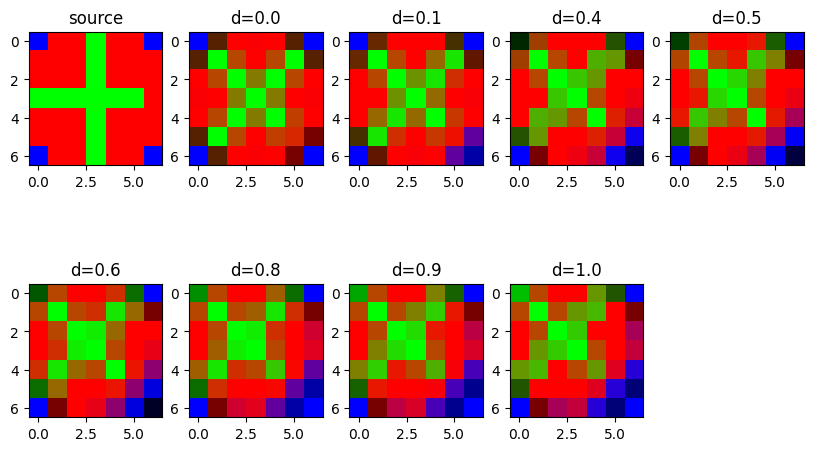

In [154]:
ds = (0.0, 0.1, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0)
img = test_image_at_90(0)

plt.figure(figsize=(10,6))
plt.subplot(math.ceil((len(ds)+1) / 5), 5, 1)
plt.imshow(img)
plt.title('source')

i=0
for d in ds:
  out = rotated_crop(img, (3 + d, 3), np.deg2rad(45), size=(7,7), mask='none', pad_value=(0,0,1), interpolation=cv2.INTER_AREA)

  plt.subplot(math.ceil((len(ds)+1) / 5), 5, i+2)
  plt.title(f"d={d}")
  plt.imshow(out)
  i += 1
plt.show()